<a href="https://colab.research.google.com/github/Hrayyan/Business_CASE_Zee_Recommender_System/blob/main/Zee_Recommender_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Business Problem & Required Outcome**



*   Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience

*   The focus is on leveraging user ratings and similarities among users to create a robust, personalized movie recommender system.
*   Utilizing a comprehensive dataset of movie ratings, user demographics, and movie details, Develop a system that can accurately predict user preferences and suggest movies accordingly.


*   The insights gained from this system are expected to drive user engagement, increase satisfaction, and foster a more intuitive user experience.



**Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import re

!pip install category_encoders
from category_encoders import TargetEncoder
!pip install sklearn
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler, MinMaxScaler

from scipy.stats import pearsonr

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.neighbors import NearestNeighbors

!pip install cmfrec
from cmfrec import CMF

from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape)

from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
!pip install umap-learn
!pip install umap-learn[plot]
import umap
import umap.plot


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 829.1 kB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.3/268.3 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached findblas-0.1.26.post1-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.5.1.post10-cp310-cp310-linux_x86_64.whl size=5669291 sha256=f3dbbfec908068e32ce3cf889574a227a6c7221786fbe0e43db25067

**Loading Data & Checking Structures**

In [ ]:
!pip install gdown

In [ ]:

!gdown 15QeQgmjoeBxRDEOFPSrMr8eIvwk6QgUQ

Downloading...
From: https://drive.google.com/uc?id=15QeQgmjoeBxRDEOFPSrMr8eIvwk6QgUQ
To: /content/zee-movies.dat
100% 171k/171k [00:00<00:00, 67.0MB/s]


In [ ]:

!gdown 1XJpSzv-UMeSmCCOdyZviRF4XCxiKJUrk

Downloading...
From: https://drive.google.com/uc?id=1XJpSzv-UMeSmCCOdyZviRF4XCxiKJUrk
To: /content/zee-ratings.dat
100% 24.6M/24.6M [00:00<00:00, 32.8MB/s]


In [ ]:

!gdown 1-xsSNizet0ruiMgKLWRcmme8L_iDejhc

Downloading...
From: https://drive.google.com/uc?id=1-xsSNizet0ruiMgKLWRcmme8L_iDejhc
To: /content/zee-users.dat
100% 134k/134k [00:00<00:00, 91.0MB/s]


In [ ]:

movies=pd.read_fwf("zee-movies.dat",encoding='ISO-8859-1')

In [ ]:

movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3883 non-null   object
 1   Unnamed: 1               100 non-null    object
 2   Unnamed: 2               51 non-null     object
dtypes: object(3)
memory usage: 91.1+ KB


In [ ]:

movies.shape

(3883, 3)

In [ ]:

movies.head(5)

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [ ]:

ratings=pd.read_fwf("zee-ratings.dat",encoding='ISO-8859-1')

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 1 columns):
 #   Column                              Non-Null Count    Dtype 
---  ------                              --------------    ----- 
 0   UserID::MovieID::Rating::Timestamp  1000209 non-null  object
dtypes: object(1)
memory usage: 7.6+ MB


In [ ]:
ratings.shape

(1000209, 1)

In [ ]:
ratings.head(5)

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [ ]:
users=pd.read_fwf("zee-users.dat",encoding='ISO-8859-1')

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   UserID::Gender::Age::Occupation::Zip-code  6040 non-null   object
dtypes: object(1)
memory usage: 47.3+ KB


In [ ]:
users.shape

(6040, 1)

In [ ]:

users.head(5)

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


**Extracting Features from each Dataset**

Movies

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3883 non-null   object
 1   Unnamed: 1               100 non-null    object
 2   Unnamed: 2               51 non-null     object
dtypes: object(3)
memory usage: 91.1+ KB


Let drop the Columns with Incompletely Filled Data

In [ ]:

a= movies["Unnamed: 1"].isnull() & movies["Unnamed: 2"].isnull()
a.sum()

3783

In [ ]:

movies = movies[movies["Unnamed: 1"].isnull() & movies["Unnamed: 2"].isnull()]

In [ ]:

movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3783 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3783 non-null   object
 1   Unnamed: 1               0 non-null      object
 2   Unnamed: 2               0 non-null      object
dtypes: object(3)
memory usage: 118.2+ KB


In [ ]:

movies.drop(columns = ["Unnamed: 1","Unnamed: 2"], inplace=True)

In [ ]:
movies.shape

(3783, 1)

In [ ]:
movies.head(5)

,Movie ID::Title::Genres
0,1::Toy Story (1995)::Animation|Children's|Comedy
1,2::Jumanji (1995)::Adventure|Children's|Fantasy
2,3::Grumpier Old Men (1995)::Comedy|Romance
3,4::Waiting to Exhale (1995)::Comedy|Drama
4,5::Father of the Bride Part II (1995)::Comedy


Lets Extract Features

In [ ]:
movies["Movie ID"] = movies["Movie ID::Title::Genres"].str.split("::").transform(lambda x : x[0])
movies["Title"] = movies["Movie ID::Title::Genres"].str.split("::").transform(lambda x : x[1])
movies["Genres"] = movies["Movie ID::Title::Genres"].str.split("::").transform(lambda x : x[2])

In [ ]:
movies.head()

,Movie ID::Title::Genres,Movie ID,Title,Genres
0,1::Toy Story (1995)::Animation|Children's|Comedy,1,Toy Story (1995),Animation|Children's|Comedy
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3::Grumpier Old Men (1995)::Comedy|Romance,3,Grumpier Old Men (1995),Comedy|Romance
3,4::Waiting to Exhale (1995)::Comedy|Drama,4,Waiting to Exhale (1995),Comedy|Drama
4,5::Father of the Bride Part II (1995)::Comedy,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies["Genressplit"] = movies["Genres"].str.split("|")

In [ ]:
movies = movies.explode("Genressplit")

In [ ]:

movies.drop(columns= ["Movie ID::Title::Genres"], inplace = True)

In [ ]:
movies.head()

,Movie ID,Title,Genres,Genressplit
0,1,Toy Story (1995),Animation|Children's|Comedy,Animation
0,1,Toy Story (1995),Animation|Children's|Comedy,Children's
0,1,Toy Story (1995),Animation|Children's|Comedy,Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Adventure
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Children's


Lets Extract Release Year Features also

In [ ]:
movies["Releaseyear"] = movies["Title"].str.split("(").transform(lambda x : x[-1])
movies["Title"] = movies["Title"].str.split("(").transform(lambda x : x[0])

In [ ]:
movies["Releaseyear"] = movies["Releaseyear"].str.split(")").transform(lambda x : x[0])

In [ ]:
movies["Releaseyear"].value_counts()

Releaseyear
1998    556
1996    527
1997    526
1995    525
1999    417
       ... 
1923      3
1919      3
1922      2
1920      2
1921      1
Name: count, Length: 81, dtype: int64

In [ ]:

movies["Genres"]=movies["Genres"].astype("category")
movies["Releaseyear"]=movies["Releaseyear"].astype("int")

In [ ]:

movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6174 entries, 0 to 3882
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Movie ID     6174 non-null   object  
 1   Title        6174 non-null   object  
 2   Genres       6174 non-null   category
 3   Genressplit  6174 non-null   object  
 4   Releaseyear  6174 non-null   int64   
dtypes: category(1), int64(1), object(3)
memory usage: 263.6+ KB


In [ ]:

movies.head()

,Movie ID,Title,Genres,Genressplit,Releaseyear
0,1,Toy Story,Animation|Children's|Comedy,Animation,1995
0,1,Toy Story,Animation|Children's|Comedy,Children's,1995
0,1,Toy Story,Animation|Children's|Comedy,Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,Adventure,1995
1,2,Jumanji,Adventure|Children's|Fantasy,Children's,1995


USERS

In [ ]:
users.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


In [ ]:

users["USerID"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[0])
users["Gender"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[1])
users["Age"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[2])
users["Occupation"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[3])
users["Zipcode"] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::").transform(lambda x : x[4])

In [ ]:
users.drop(columns= ["UserID::Gender::Age::Occupation::Zip-code"], inplace = True)

In [ ]:

users["Gender"]=users["Gender"].astype("category")
users["Occupation"]=users["Occupation"].astype("category")
users["Age"]=users["Age"].astype("category")
users["Zipcode"]=users["Zipcode"].astype("category")

In [ ]:

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   USerID      6040 non-null   object  
 1   Gender      6040 non-null   category
 2   Age         6040 non-null   category
 3   Occupation  6040 non-null   category
 4   Zipcode     6040 non-null   category
dtypes: category(4), object(1)
memory usage: 233.9+ KB


In [ ]:

users.head()

,USerID,Gender,Age,Occupation,Zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


RATINGS

In [ ]:

ratings.head(5)

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [ ]:

ratings["USerID"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[0])
ratings["Movie ID"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[1])
ratings["Rating"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[2])
ratings["Timestamp"] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::").transform(lambda x : x[3])


In [ ]:

ratings.drop(columns= ["UserID::MovieID::Rating::Timestamp"], inplace = True)

In [ ]:

ratings["Rating"]=ratings["Rating"].astype("int")
ratings["Timestamp"]=ratings["Timestamp"].astype("int")

In [ ]:
ratings['hour'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).hour)

ratings['dayofweek'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).weekday())

ratings['month'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).month)

ratings['year'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).year)

ratings['day'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).day)

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 9 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   USerID     1000209 non-null  object
 1   Movie ID   1000209 non-null  object
 2   Rating     1000209 non-null  int64 
 3   Timestamp  1000209 non-null  int64 
 4   hour       1000209 non-null  int64 
 5   dayofweek  1000209 non-null  int64 
 6   month      1000209 non-null  int64 
 7   year       1000209 non-null  int64 
 8   day        1000209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 68.7+ MB


In [ ]:
ratings.head()

,USerID,Movie ID,Rating,Timestamp,hour,dayofweek,month,year,day
0,1,1193,5,978300760,22,6,12,2000,31
1,1,661,3,978302109,22,6,12,2000,31
2,1,914,3,978301968,22,6,12,2000,31
3,1,3408,4,978300275,22,6,12,2000,31
4,1,2355,5,978824291,23,5,1,2001,6


**Exploratory Data Analysis**

Movies

In [ ]:

movies.head()

,Movie ID,Title,Genres,Genressplit,Releaseyear
0,1,Toy Story,Animation|Children's|Comedy,Animation,1995
0,1,Toy Story,Animation|Children's|Comedy,Children's,1995
0,1,Toy Story,Animation|Children's|Comedy,Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,Adventure,1995
1,2,Jumanji,Adventure|Children's|Fantasy,Children's,1995


In [ ]:
for i in movies.columns:
  print("No of Unique {} are {}".format(i,movies[i].nunique()))

No of Unique Movie ID are 3783
No of Unique Title are 3733
No of Unique Genres are 296
No of Unique Genressplit are 25
No of Unique Releaseyear are 81


In [ ]:

movies["Genressplit"].value_counts().reset_index()

,Genressplit,count
0,Drama,1568
1,Comedy,1170
2,Action,485
3,Thriller,484
4,Romance,452
5,Horror,332
6,Adventure,257
7,Sci-Fi,255
8,Children's,227
9,Crime,208


Some of the Genres are not completely spelled, we will correct them so that they do no behave as separate Genre

In [ ]:

movies.loc[movies["Genressplit"] =="Horro","Genressplit"] = "Horror"
movies.loc[movies["Genressplit"] =="Fantas","Genressplit"] = "Fantasy"
movies.loc[movies["Genressplit"] =="Dram","Genressplit"] = "Drama"
movies.loc[movies["Genressplit"] =="Wester","Genressplit"] = "Western"
movies.loc[movies["Genressplit"] =="Sci-F","Genressplit"] = "Sci-Fi"
movies.loc[movies["Genressplit"] =="Thrille","Genressplit"] = "Thriller"
movies.loc[movies["Genressplit"] =="Wa","Genressplit"] = "War"

In [ ]:
movies["Genressplit"].nunique()

18

In [ ]:

movies.Releaseyear.describe()

count    6174.000000
mean     1986.229997
std        16.547598
min      1919.000000
25%      1983.000000
50%      1994.000000
75%      1997.000000
max      2000.000000
Name: Releaseyear, dtype: float64

<Axes: xlabel='Releaseyear', ylabel='Count'>

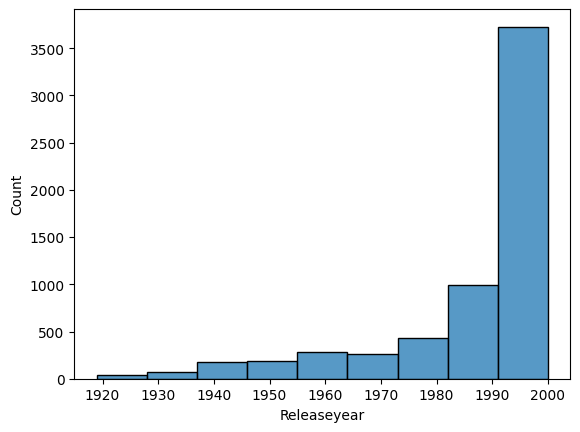

In [ ]:

sns.histplot(data=movies, x= "Releaseyear", bins =9)

More than 75% of the movies have release year after 1983
lets Convert Release year into bins as Release year recency factor

In [ ]:

bins = [1919,1940,1960,1980,1990,2000]
movies["Releaseyeargroups"] = pd.cut(movies["Releaseyear"], bins, labels=[1,2,3,4,5])

<Axes: xlabel='count', ylabel='Releaseyeargroups'>

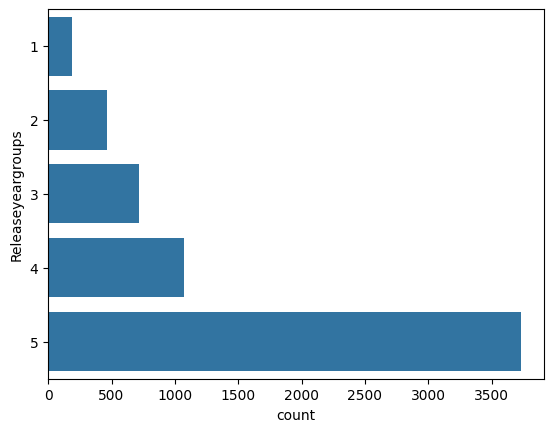

In [ ]:
sns.countplot( movies["Releaseyeargroups"])

In [ ]:
for i in movies.columns:
  print("No of Unique {} are {}".format(i,movies[i].nunique()))

No of Unique Movie ID are 3783
No of Unique Title are 3733
No of Unique Genres are 296
No of Unique Genressplit are 18
No of Unique Releaseyear are 81
No of Unique Releaseyeargroups are 5


USERS

In [ ]:
for i in users.columns:
  print("No of Unique {} are {}".format(i,users[i].nunique()))

No of Unique USerID are 6040
No of Unique Gender are 2
No of Unique Age are 7
No of Unique Occupation are 21
No of Unique Zipcode are 3439


In [ ]:
users.shape

(6040, 5)

In [ ]:
users.head()

,USerID,Gender,Age,Occupation,Zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:

Occup = {0: "other",
1: "academic/educator",
2: "artist",
3: "clerical/admin",
4: "college/grad student",
5: "customer service",
6: "doctor/health care",
7: "executive/managerial",
8: "farmer",
9: "homemaker",
10: "K-12 student",
11: "lawyer",
12: "programmer",
13: "retired",
14: "sales/marketing",
15: "scientist",
16: "self-employed",
17: "technician/engineer",
18: "tradesman/craftsman",
19: "unemployed",
20: "writer"}

In [ ]:
users["Occupation"].value_counts()

Occupation
4     759
0     711
7     679
1     528
17    502
12    388
14    302
20    281
2     267
16    241
6     236
10    195
3     173
15    144
13    142
11    129
5     112
9      92
19     72
18     70
8      17
Name: count, dtype: int64

Majority of the Users occupation

*college/grad student

*executive/managerial

*academic/educator

Minimum no of users are from below Occupations

*Farmers

*tradesman/craftsman

*homemakers

In [ ]:

users["Age"].value_counts()


Age
25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: count, dtype: int64

In [ ]:

users["Zipcode"].value_counts().head(5)

Zipcode
48104    19
22903    18
94110    17
55104    17
10025    16
Name: count, dtype: int64

In [ ]:

users["Zipcode"].value_counts().tail(5)

Zipcode
37843    1
37877    1
37909    1
37914    1
99945    1
Name: count, dtype: int64

Ratings

In [ ]:

ratings.head()

,USerID,Movie ID,Rating,Timestamp,hour,dayofweek,month,year,day
0,1,1193,5,978300760,22,6,12,2000,31
1,1,661,3,978302109,22,6,12,2000,31
2,1,914,3,978301968,22,6,12,2000,31
3,1,3408,4,978300275,22,6,12,2000,31
4,1,2355,5,978824291,23,5,1,2001,6


In [ ]:

for i in ratings.columns:
  print("No of Unique {} are {}".format(i,ratings[i].nunique()))


No of Unique USerID are 6040
No of Unique Movie ID are 3706
No of Unique Rating are 5
No of Unique Timestamp are 458455
No of Unique hour are 24
No of Unique dayofweek are 7
No of Unique month are 12
No of Unique year are 4
No of Unique day are 31


In [ ]:
ratings.shape

(1000209, 9)

In [ ]:

ratings["Rating"].value_counts()

Rating
4    348971
3    261197
5    226310
2    107557
1     56174
Name: count, dtype: int64

<Axes: xlabel='hour', ylabel='count'>

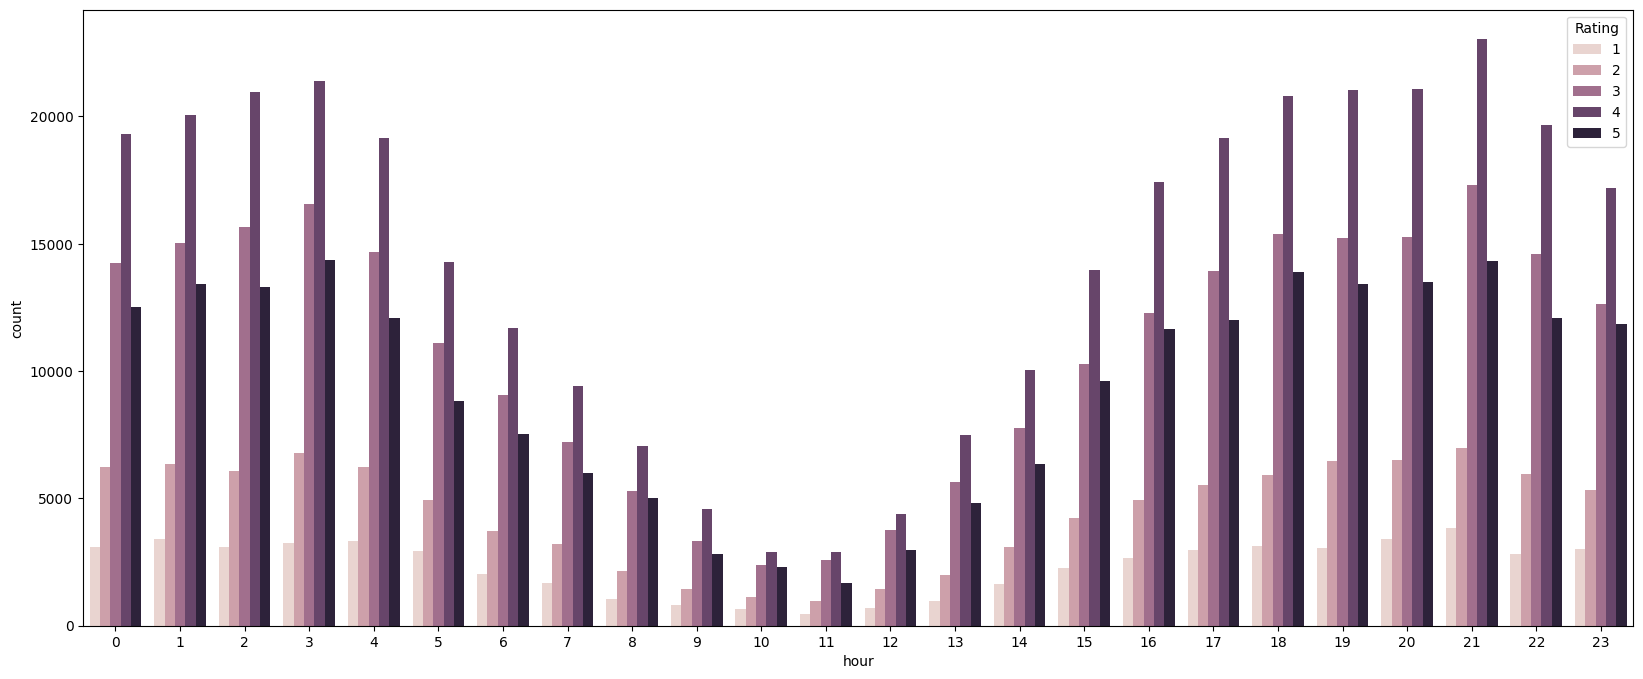

In [ ]:
plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "hour",hue = "Rating")

*Most of the movies are rated/watched in the Night and midnight

*Movies are least watched in morning and noon time

<Axes: xlabel='dayofweek', ylabel='count'>

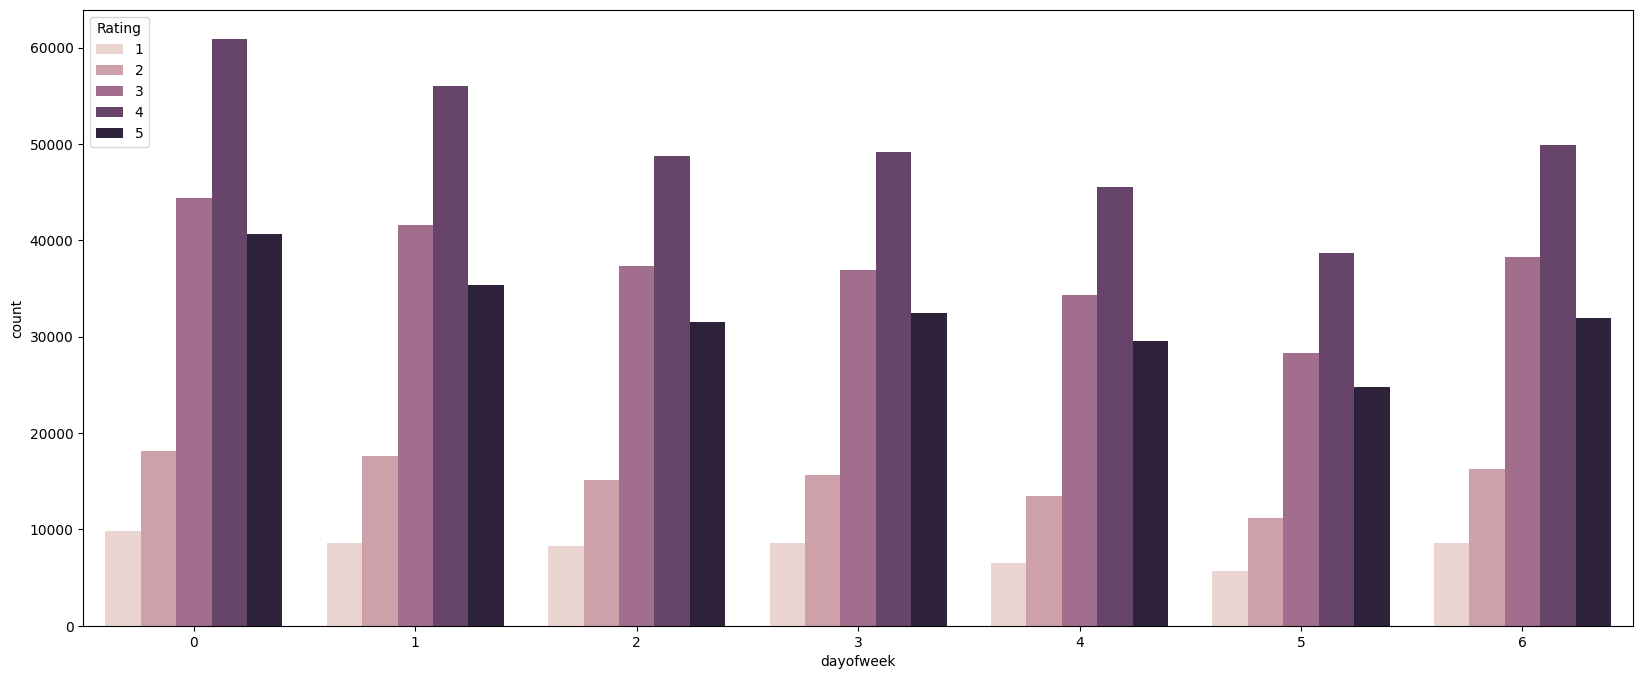

In [ ]:

plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "dayofweek",hue = "Rating")

*Comparitively movies are mostly watched in Saturdays and Sunday

*Least rated/watched on Fridays

<Axes: xlabel='month', ylabel='count'>

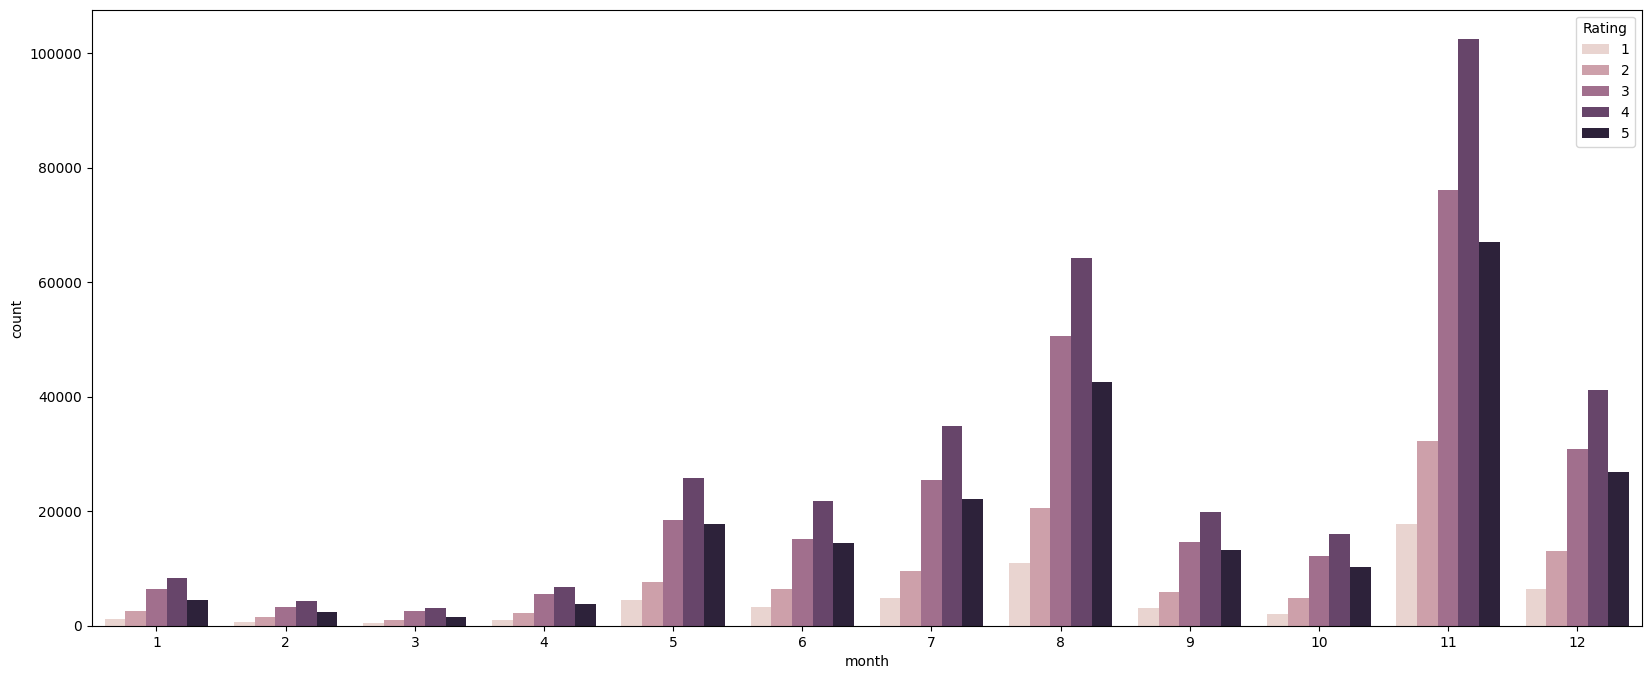

In [ ]:

plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "month",hue = "Rating")


*Most movies are watched /rated in the month of November & next in August

*leastly watchd /rated in the month of March

<Axes: xlabel='year', ylabel='count'>

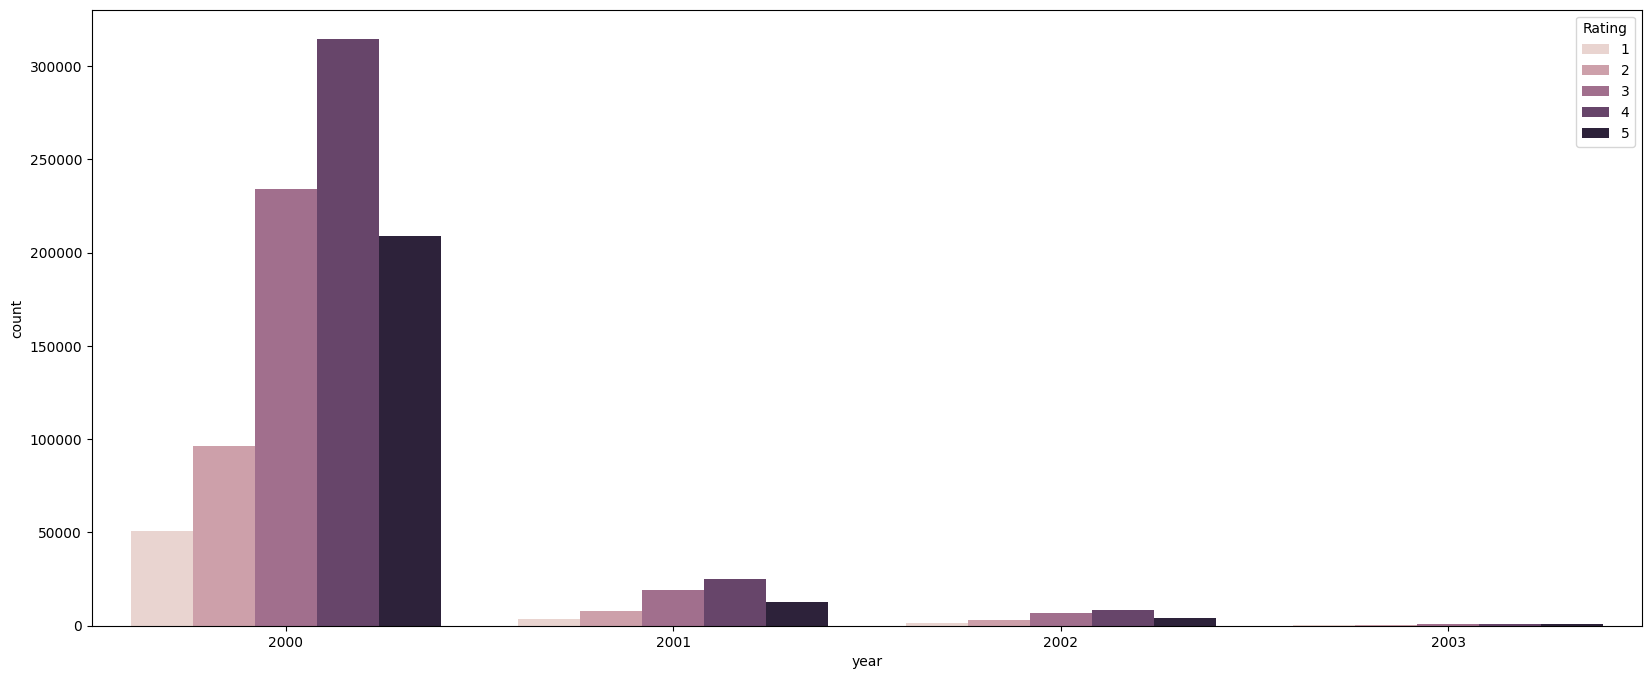

In [ ]:
plt.figure(figsize =(20,8))
sns.countplot(data= ratings, x= "year",hue = "Rating")


In [ ]:
ratings.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day'],
      dtype='object')

**Creating Matrices for Recommendation Systems**

Combination 3 Data frames

In [ ]:
movies.columns

Index(['Movie ID', 'Title', 'Genres', 'Genressplit', 'Releaseyear',
       'Releaseyeargroups'],
      dtype='object')

Index(['Movie ID', 'Title', 'Genres', 'Genressplit', 'Releaseyear',
       'Releaseyeargroups'],
      dtype='object')

In [ ]:
data = ratings.merge(users[["USerID","Gender","Age","Occupation"]],on = "USerID", how = "right")

In [ ]:
data = data.merge(movies[["Movie ID","Title","Genres","Releaseyeargroups","Releaseyear"]],on = "Movie ID", how = 'right')


In [ ]:
data.shape

(1978767, 16)

In [ ]:
data.head()

,USerID,Movie ID,Rating,Timestamp,hour,dayofweek,month,year,day,Gender,Age,Occupation,Title,Genres,Releaseyeargroups,Releaseyear
0,1,1,5.0,978824268.0,23.0,5.0,1.0,2001.0,6.0,F,1,10,Toy Story,Animation|Children's|Comedy,5,1995
1,6,1,4.0,978237008.0,4.0,6.0,12.0,2000.0,31.0,F,50,9,Toy Story,Animation|Children's|Comedy,5,1995
2,8,1,4.0,978233496.0,3.0,6.0,12.0,2000.0,31.0,M,25,12,Toy Story,Animation|Children's|Comedy,5,1995
3,9,1,5.0,978225952.0,1.0,6.0,12.0,2000.0,31.0,M,25,17,Toy Story,Animation|Children's|Comedy,5,1995
4,10,1,5.0,978226474.0,1.0,6.0,12.0,2000.0,31.0,F,35,1,Toy Story,Animation|Children's|Comedy,5,1995


In [ ]:

data[data["Title"] == "Liar Liar (1997)"]

,USerID,Movie ID,Rating,Timestamp,hour,dayofweek,month,year,day,Gender,Age,Occupation,Title,Genres,Releaseyeargroups,Releaseyear


Now we have all the required information in one Dataframe, from this Dataframe we can extract information for User-User and Item-Item Based Recommendation Approach

In [ ]:
data1 = ratings.merge(users[["USerID","Gender","Age","Occupation"]],on = "USerID", how = "right")
data1 = data1.merge(movies[["Movie ID","Genres","Genressplit","Releaseyeargroups","Releaseyear"]],on = "Movie ID", how = 'right')


In [ ]:

data1.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day', 'Gender', 'Age', 'Occupation', 'Genres',
       'Genressplit', 'Releaseyeargroups', 'Releaseyear'],
      dtype='object')

EDA on Combined DataFrame

<Axes: xlabel='Rating', ylabel='Gender'>

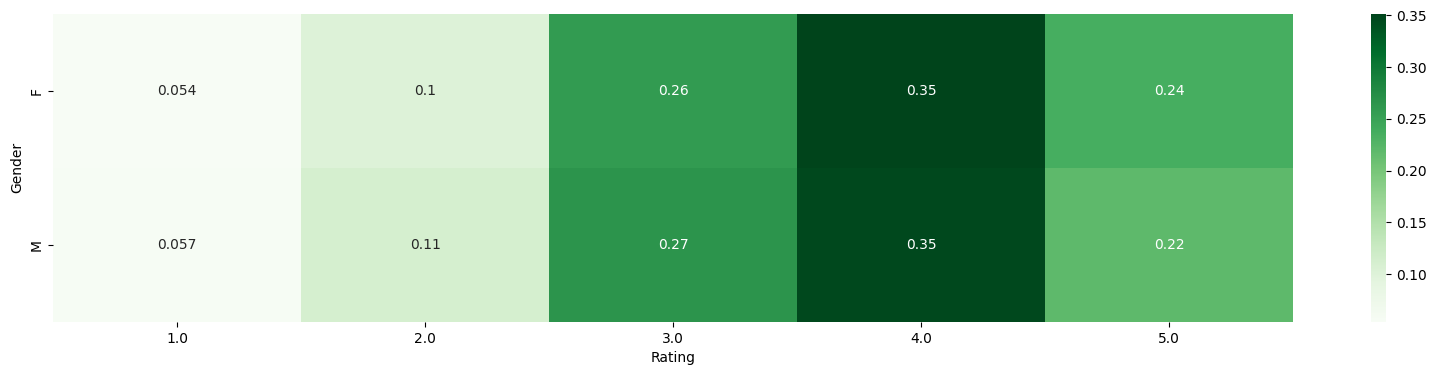

In [ ]:
plt.figure(figsize = (20,4))
sns.heatmap(pd.crosstab(data["Gender"], data["Rating"], normalize = "index"),annot=True,cmap = "Greens")


Gender has no Bias in Rating Viewpoint for Movies

<Axes: xlabel='Rating', ylabel='Age'>

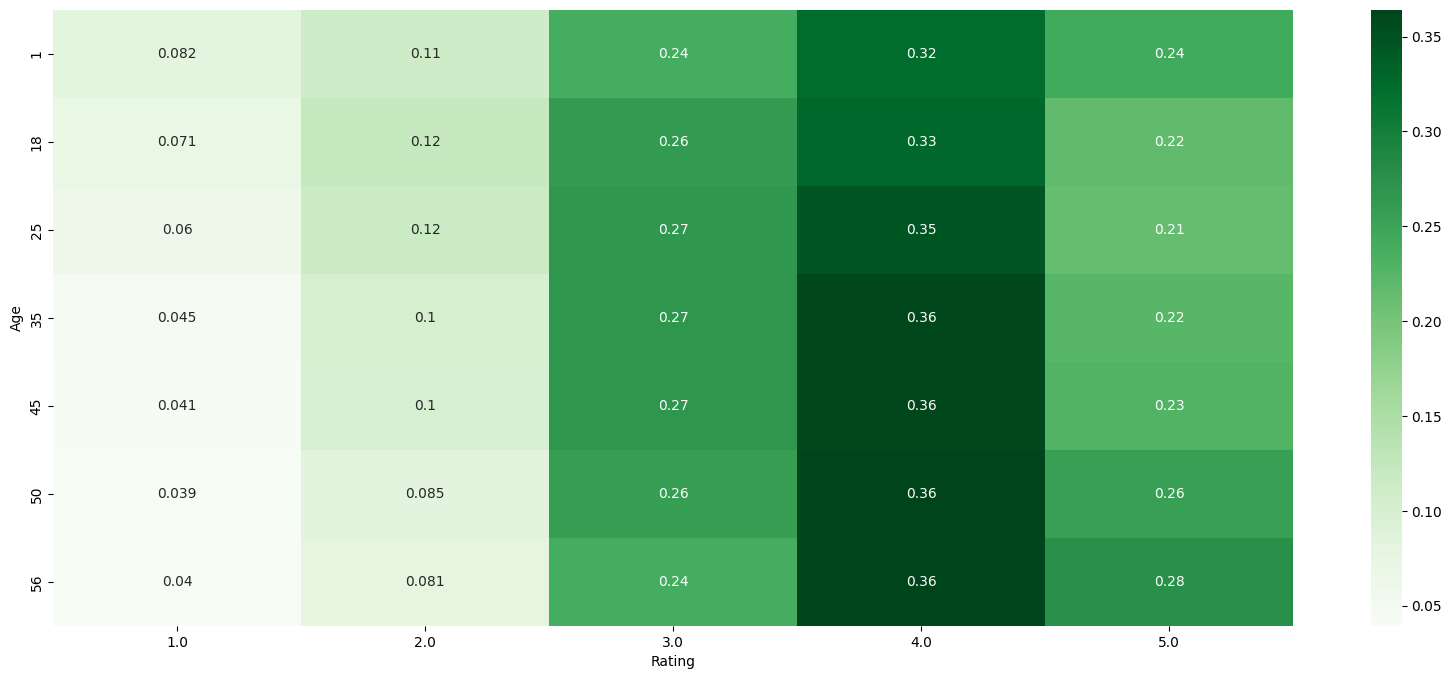

In [ ]:
plt.figure(figsize = (20,8))
sns.heatmap(data=pd.crosstab(data["Age"], data["Rating"], normalize = "index"),annot=True,cmap = "Greens")


Age Groups 18 ~ 25, 25 ~ 34, 35 ~ 44, 45 ~ 49 are comparively critical in rating movies in caomparison with other age groups

<Axes: xlabel='Genressplit', ylabel='Age'>

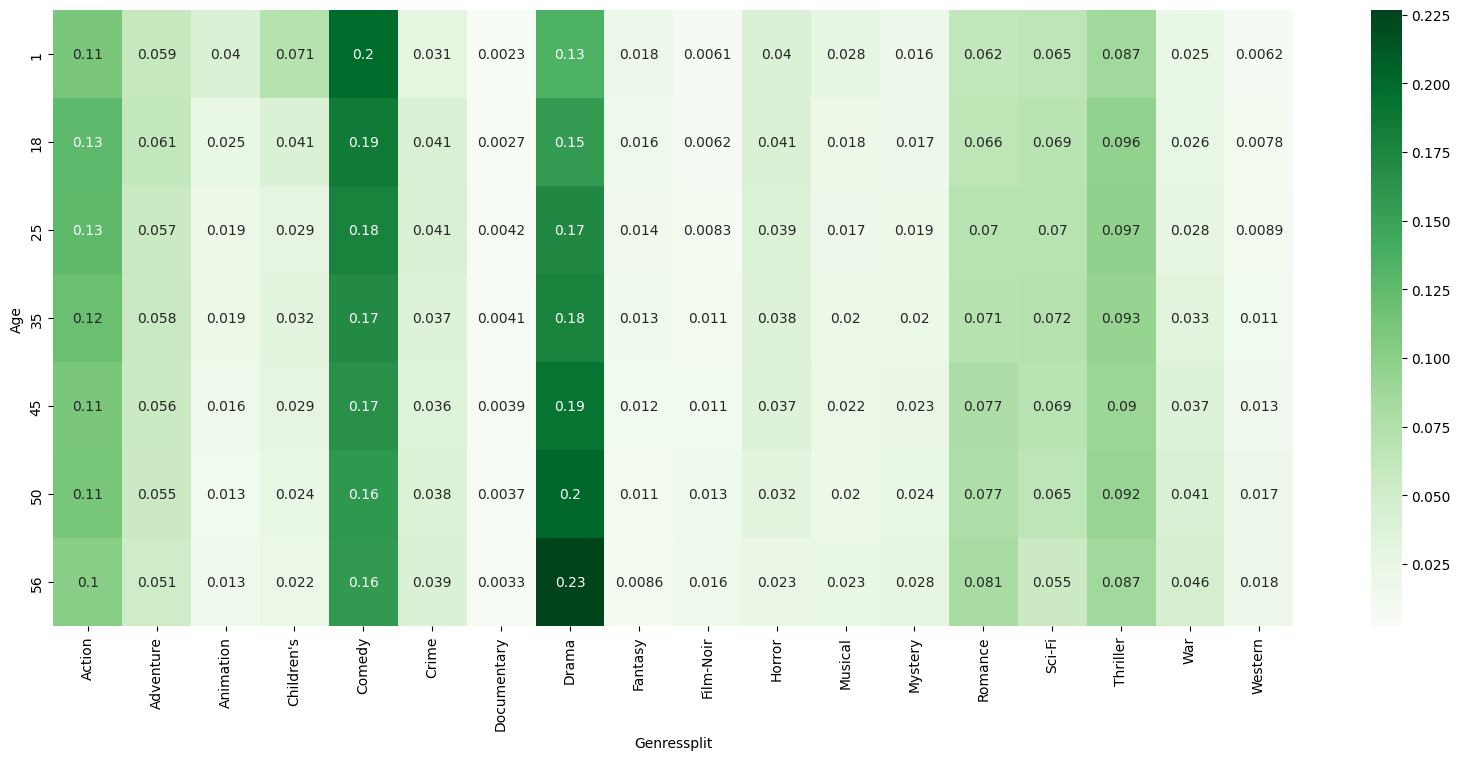

In [ ]:
plt.figure(figsize = (20,8))
sns.heatmap(data=pd.crosstab(data1["Age"], data1["Genressplit"], normalize = "index"),annot=True,cmap = "Greens")

All Age groups have almost preference order for Genres : Drama--> Comedy --> Action --> Thriller

<Axes: xlabel='Genressplit', ylabel='Gender'>

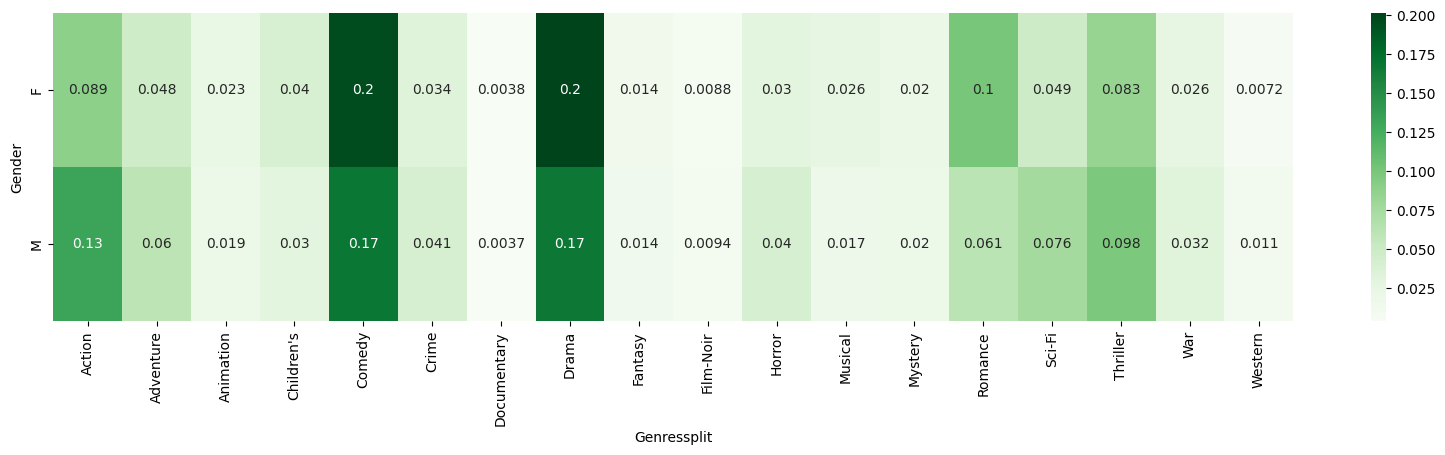

In [ ]:
plt.figure(figsize = (20,4))
sns.heatmap(data=pd.crosstab(data1["Gender"], data1["Genressplit"], normalize = "index"),annot=True,cmap = "Greens")


Female has more preference in Genres - Romance,Comedy,Drama in Comparison with Male

Male has more preference in Genres - Action,Mystery in comparsion with Female

<Axes: xlabel='Genressplit', ylabel='Occupation'>

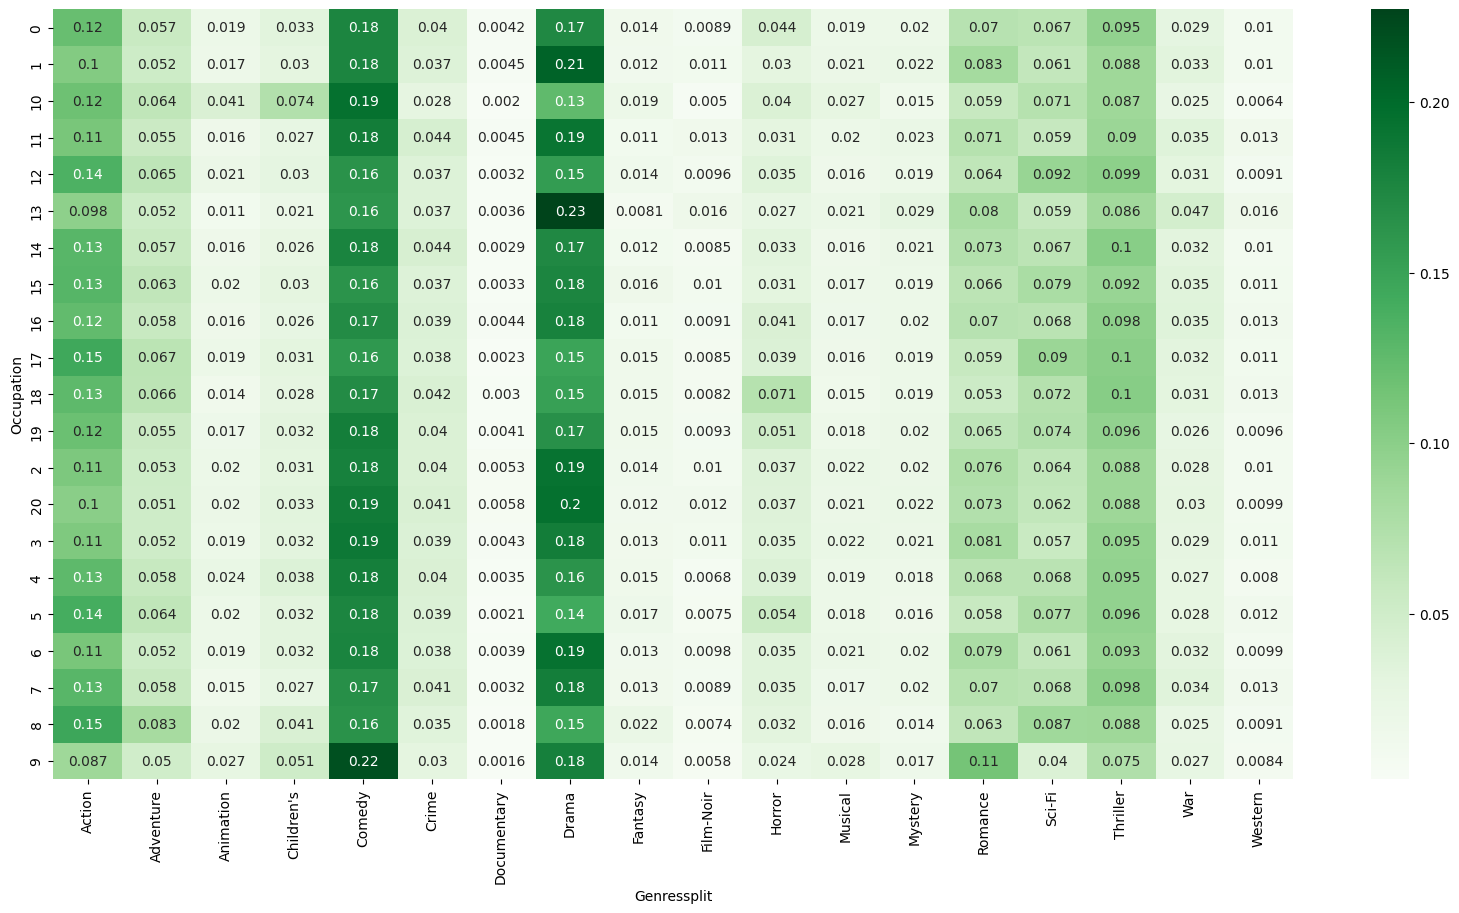

In [ ]:
plt.figure(figsize = (20,10))
sns.heatmap(data=pd.crosstab(data1["Occupation"], data1["Genressplit"], normalize = "index"),annot=True,cmap = "Greens")


Comparitively Retired & Homemaker People less preference for Action & have more prefence for Comedy and Drama

<Axes: xlabel='hour', ylabel='Age'>

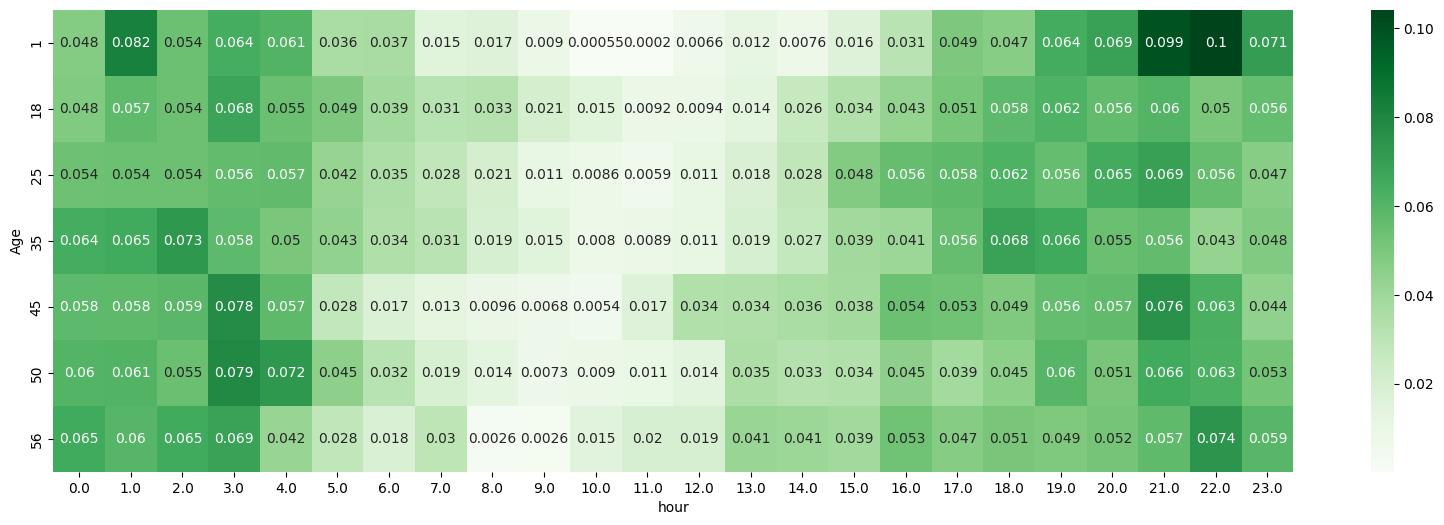

In [ ]:
plt.figure(figsize = (20,6))
sns.heatmap(data=pd.crosstab(data1["Age"], data1["hour"], normalize = "index"),annot=True,cmap = "Greens")


Compariively 1~18 Age user watch/rate movie in the late night between 21:00 ~ 23:00

In [ ]:

data["Age"].value_counts()

Age
25    783871
35    393419
18    366971
45    163911
50    141588
56     74529
1      54270
Name: count, dtype: int64

Most of the Movie Rating are given by 25 ~ 34 Age Group

In [ ]:

data["Occupation"].value_counts()[:5]

Occupation
4     260352
0     257151
7     208797
1     165346
17    150331
Name: count, dtype: int64

Occupation:"college/grad student" have rated most Movies, next most rated are others ,executive/managerial,academic/educator,technician/engineer

In [ ]:

data["Gender"].value_counts()


Gender
M    1501710
F     476849
Name: count, dtype: int64

Nearly 80% of ratings are done by Males

In [ ]:


data["Title"].value_counts()[:5]

Title
Men in Black                   10152
Princess Bride, The             9272
L.A. Confidential               9152
E.T. the Extra-Terrestrial      9076
Alien                           8096
Name: count, dtype: int64

**Selecting 1000 Most Rated Movies & 1000 Most Watched users**

In [ ]:

movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6174 entries, 0 to 3882
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Movie ID           6174 non-null   object  
 1   Title              6174 non-null   object  
 2   Genres             6174 non-null   category
 3   Genressplit        6174 non-null   object  
 4   Releaseyear        6174 non-null   int64   
 5   Releaseyeargroups  6171 non-null   category
dtypes: category(2), int64(1), object(3)
memory usage: 269.9+ KB


In [ ]:

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   USerID      6040 non-null   object  
 1   Gender      6040 non-null   category
 2   Age         6040 non-null   category
 3   Occupation  6040 non-null   category
 4   Zipcode     6040 non-null   category
dtypes: category(4), object(1)
memory usage: 233.9+ KB


In [ ]:

ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 9 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   USerID     1000209 non-null  object
 1   Movie ID   1000209 non-null  object
 2   Rating     1000209 non-null  int64 
 3   Timestamp  1000209 non-null  int64 
 4   hour       1000209 non-null  int64 
 5   dayofweek  1000209 non-null  int64 
 6   month      1000209 non-null  int64 
 7   year       1000209 non-null  int64 
 8   day        1000209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 68.7+ MB


In [ ]:

select_movies = ratings['Movie ID'].value_counts()[:1000].index.to_list()


In [ ]:

movies = movies.loc[movies["Movie ID"].isin(select_movies)]
movies.shape

(2024, 6)

In [ ]:

select_users = ratings['USerID'].value_counts()[:1000].index.to_list()

In [ ]:

users = users.loc[users["USerID"].isin(select_users)]
users.shape

(1000, 5)

**Item-Item Similarity Matrix**

In [ ]:
movies.columns

Index(['Movie ID', 'Title', 'Genres', 'Genressplit', 'Releaseyear',
       'Releaseyeargroups'],
      dtype='object')

In [ ]:

item_item = movies[['Movie ID','Releaseyear']].drop_duplicates()

In [ ]:
item_item.head()

,Movie ID,Releaseyear
0,1,1995
1,2,1995
2,3,1995
5,6,1995
6,7,1995


In [ ]:
item_item.shape

(976, 2)

**Adding Average Rating of an Item**

In [ ]:
item_item = item_item.merge(data.groupby('Movie ID').Rating.mean().reset_index(), on='Movie ID', how = "left")


In [ ]:

item_item.head()

,Movie ID,Releaseyear,Rating
0,1,1995,4.146846
1,2,1995,3.201141
2,3,1995,3.016736
3,6,1995,3.878723
4,7,1995,3.410480


**Adding Genre By doing sort of OHE**

In [ ]:

m = movies.pivot(index='Movie ID', columns='Genressplit', values='Title')
m = ~m.isna()
m = m.astype(int)

In [ ]:
m.head()

Genressplit,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Movie ID,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1020,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1022,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1027,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
item_item = item_item.merge(m, on='Movie ID', how = "left")

Adding Gender wise Ratings for an item

In [ ]:

item_item = item_item.merge(
    data.groupby(['Movie ID', 'Gender'])['Rating'].mean().
    reset_index().pivot(index='Movie ID', columns='Gender', values='Rating').
    reset_index(), on='Movie ID', how = "left")

In [ ]:
item_item.head()


,Movie ID,Releaseyear,Rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,F,M
0,1,1995,4.146846,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,4.187817,4.130552
1,2,1995,3.201141,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3.278409,3.175238
2,3,1995,3.016736,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,3.073529,2.994152
3,6,1995,3.878723,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,3.682171,3.909988
4,7,1995,3.410480,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,3.588235,3.267717


In [ ]:

data.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day', 'Gender', 'Age', 'Occupation', 'Title',
       'Genres', 'Releaseyeargroups', 'Releaseyear'],
      dtype='object')

Adding Age wise Ratings for an item

In [ ]:
item_item = item_item.merge(
    data.groupby(['Movie ID', 'Age'])['Rating'].mean().
    reset_index().pivot(index='Movie ID', columns='Age', values='Rating').
    reset_index(), on='Movie ID', how = "left")


Adding Occupation wise Ratings for an item

In [ ]:
item_item = item_item.merge(
    data.groupby(['Movie ID', 'Occupation'])['Rating'].mean().
    reset_index().pivot(index='Movie ID', columns='Occupation', values='Rating').
    reset_index(), on='Movie ID', how = "left")

In [ ]:

item_item.shape

(976, 51)

Final item_item Matrix

In [ ]:

item_item.shape

(976, 51)

In [ ]:

item_item.columns

Index(['Movie ID', 'Releaseyear', 'Rating', 'Action', 'Adventure', 'Animation',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'F', 'M', '1_x', '18_x', '25', '35', '45',
       '50', '56', '0', '1_y', '10', '11', '12', '13', '14', '15', '16', '17',
       '18_y', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9'],
      dtype='object')

In [ ]:

item_item =item_item.set_index("Movie ID")


In [ ]:

item_item.fillna(0, inplace=True)

In [ ]:

item_item.head(10)

,Releaseyear,Rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,19,2,20,3,4,5,6,7,8,9
Movie ID,,,,,,,,,,,,,,,,,,,,,
1,1995,4.146846,0,0,1,1,1,0,0,0,...,3.960000,4.000000,4.046296,4.492537,4.040404,4.025641,4.394737,4.189055,4.500000,4.028571
2,1995,3.201141,0,1,0,1,0,0,0,0,...,3.100000,2.970588,3.071429,3.285714,3.116505,3.400000,3.107143,3.115942,2.666667,3.500000
3,1995,3.016736,0,0,0,0,1,0,0,0,...,3.333333,2.777778,2.789474,2.909091,3.060606,2.750000,2.714286,3.045455,3.000000,2.875000
6,1995,3.878723,1,0,0,0,0,1,0,0,...,4.000000,3.853659,3.368421,3.625000,4.034965,3.909091,4.068966,3.923810,4.000000,4.500000
7,1995,3.410480,0,0,0,0,1,0,0,0,...,2.625000,3.208333,3.090909,3.200000,3.500000,3.571429,3.214286,3.183673,3.000000,4.250000
10,1995,3.540541,1,1,0,0,0,0,0,0,...,2.777778,3.694444,3.222222,3.608696,3.633333,3.300000,3.720000,3.597938,3.250000,3.100000
11,1995,3.793804,0,0,0,0,1,0,0,1,...,3.272727,3.595745,3.340426,3.833333,3.771654,4.187500,3.830189,3.832000,4.333333,4.142857
16,1995,3.793255,0,0,0,0,0,0,0,1,...,3.272727,3.642857,3.500000,3.791667,3.870000,4.000000,3.920000,3.896104,3.000000,4.000000
17,1995,4.027545,0,0,0,0,0,0,0,1,...,3.600000,3.894737,4.033333,4.000000,4.020619,4.142857,4.128205,4.045455,5.000000,4.413793


In [ ]:

scaler = MinMaxScaler()
item_item_scaled = pd.DataFrame(scaler.fit_transform(item_item), columns=item_item.columns, index=item_item.index)
item_item_scaled.head()

,Releaseyear,Rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,19,2,20,3,4,5,6,7,8,9
Movie ID,,,,,,,,,,,,,,,,,,,,,
1,0.932432,0.861485,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.740000,0.779528,0.836279,0.927919,0.799284,0.805128,0.905427,0.835363,0.900000,0.805714
2,0.932432,0.540193,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.525000,0.467462,0.562667,0.553710,0.510963,0.680000,0.520807,0.474001,0.533333,0.700000
3,0.932432,0.477544,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.583333,0.409011,0.483532,0.436927,0.493519,0.550000,0.403455,0.450265,0.600000,0.575000
6,0.932432,0.770394,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.750000,0.735164,0.646023,0.658915,0.797586,0.781818,0.808115,0.746044,0.800000,0.900000
7,0.932432,0.611314,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.406250,0.539534,0.568135,0.527132,0.630640,0.714286,0.552812,0.496809,0.600000,0.850000


In [ ]:

item_item_scaled.describe()

,Releaseyear,Rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,19,2,20,3,4,5,6,7,8,9
count,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,...,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000
mean,0.820586,0.672058,0.258197,0.120902,0.047131,0.065574,0.360656,0.081967,0.003074,0.345287,...,0.622864,0.638744,0.671916,0.667072,0.660315,0.722198,0.682662,0.628470,0.615914,0.707783
std,0.190585,0.164587,0.437867,0.326180,0.212028,0.247662,0.480437,0.274455,0.055385,0.475705,...,0.154254,0.163153,0.168326,0.158669,0.163399,0.103294,0.158749,0.169337,0.302642,0.145646
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.756757,0.564949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.531250,0.537008,0.561331,0.574327,0.555342,0.660000,0.588373,0.521959,0.562500,0.643333
50%,0.891892,0.697272,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.642081,0.655652,0.687342,0.683995,0.679412,0.727273,0.706047,0.655582,0.700000,0.733333
75%,0.959459,0.793257,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.735294,0.757273,0.801331,0.775194,0.786675,0.800000,0.804109,0.749023,0.800000,0.800000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**User-User Similarity Matrix`**

Lets Create a Matric for User

In [ ]:
users.columns

Index(['USerID', 'Gender', 'Age', 'Occupation', 'Zipcode'], dtype='object')

In [ ]:

user_user = users[['USerID', 'Gender', 'Age', 'Occupation', 'Zipcode']].drop_duplicates()

In [ ]:
user_user.head()

,USerID,Gender,Age,Occupation,Zipcode
9,10,F,35,1,95370
17,18,F,18,3,95825
21,22,M,18,15,53706
22,23,M,35,0,90049
25,26,M,25,7,23112


Adding Average Rating of a User

In [ ]:

user_user = user_user.merge(data.groupby('USerID').Rating.mean().reset_index(), on='USerID', how = "left")

Adding count of Movies rated by a user

In [ ]:

user_user = user_user.merge(data.groupby('USerID').Rating.count().reset_index(), on='USerID', how = "left")

In [ ]:

user_user.columns

Index(['USerID', 'Gender', 'Age', 'Occupation', 'Zipcode', 'Rating_x',
       'Rating_y'],
      dtype='object')

In [ ]:

user_user.rename(columns = {'Rating_x':'Ave.rating','Rating_y':'movie_count'}, inplace = True)

In [ ]:

user_user.columns

Index(['USerID', 'Gender', 'Age', 'Occupation', 'Zipcode', 'Ave.rating',
       'movie_count'],
      dtype='object')

Adding Average Hour, weekday, day,month for rating for a user

In [ ]:

data.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day', 'Gender', 'Age', 'Occupation', 'Title',
       'Genres', 'Releaseyeargroups', 'Releaseyear'],
      dtype='object')

Label Encoding Gender

In [ ]:
le=LabelEncoder()
user_user["Gender"]=le.fit_transform(user_user["Gender"])
user_user["Gender"].value_counts()

Gender
1    769
0    231
Name: count, dtype: int64

Target Encoding Occupation and ZipCode

In [ ]:
te=TargetEncoder()
user_user["Occupation"]=te.fit_transform(user_user["Occupation"],user_user["Ave.rating"])
user_user["Zipcode"]=te.fit_transform(user_user["Zipcode"],user_user["Ave.rating"])

In [ ]:

user_user.head()

,USerID,Gender,Age,Occupation,Zipcode,Ave.rating,movie_count
0,10,0,35,3.428073,3.570591,4.135338,798
1,18,0,18,3.555448,3.499044,3.585434,714
2,22,1,18,3.556099,3.462524,3.059486,622
3,23,1,35,3.447147,3.465551,3.328012,689
4,26,1,25,3.523273,3.423584,3.005457,733


Final user_user Matrix

In [ ]:

user_user.shape

(1000, 7)

In [ ]:

user_user.columns

Index(['USerID', 'Gender', 'Age', 'Occupation', 'Zipcode', 'Ave.rating',
       'movie_count'],
      dtype='object')

In [ ]:

user_user =user_user.set_index("USerID")

In [ ]:
item_item.fillna(0, inplace=True)

In [ ]:

scaler1 = MinMaxScaler()
user_user_scaled = pd.DataFrame(scaler1.fit_transform(user_user), columns=user_user.columns, index=user_user.index)
user_user_scaled.head()

,Gender,Age,Occupation,Zipcode,Ave.rating,movie_count
USerID,,,,,,
10,0.0,0.618182,0.000000,0.826929,0.827281,0.091762
18,0.0,0.309091,0.740129,0.600966,0.601777,0.067136
22,1.0,0.309091,0.743912,0.485626,0.386096,0.040164
23,1.0,0.618182,0.110832,0.495187,0.496213,0.059807
26,1.0,0.436364,0.553172,0.362644,0.363940,0.072706


In [ ]:

user_user_scaled.describe()


,Gender,Age,Occupation,Zipcode,Ave.rating,movie_count
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.769000,0.510291,0.325449,0.560169,0.561051,0.151599
std,0.421683,0.192363,0.274928,0.161424,0.171946,0.123670
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.436364,0.094396,0.465949,0.462634,0.063544
50%,1.000000,0.436364,0.193936,0.564606,0.569379,0.114483
75%,1.000000,0.618182,0.553172,0.677380,0.683549,0.206904
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


User-Item Interaction Matrix

In [ ]:
ratings.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day'],
      dtype='object')

In [ ]:

user_item = ratings.pivot(index = 'USerID',columns ='Movie ID',values = 'Rating' )

In [ ]:

user_item.fillna(0,inplace = True)

In [ ]:

user_item.shape

(6040, 3706)

In [ ]:

user_item.head()

Movie ID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
USerID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Findind No of Ratings
(user_item >0).sum().sum()

1000209

In [ ]:

# Finding Sprsity in User_Item Interaction Matrix

(user_item >0).sum().sum() / (user_item.shape[0]*user_item.shape[1])

0.044683625622312845

Only 4.46 % of ratings are filled in User_Item Interaction Matrix

**Pearson Correlation for Item Item Recommendation**

In [ ]:

item_item_scaled.shape

(976, 50)

In [ ]:

item_item_scaled.index

Index(['1', '2', '3', '6', '7', '10', '11', '16', '17', '19',
       ...
       '3863', '3868', '3869', '3893', '3897', '3911', '3916', '3927', '3948',
       '3952'],
      dtype='object', name='Movie ID', length=976)

In [ ]:

ranks = []

for query in item_item_scaled.index:
    for candidate in item_item_scaled.index:
        if candidate == query:
            continue
        ranks.append([query, candidate, pearsonr(item_item_scaled.loc[query], item_item_scaled.loc[candidate])[0]])


Pearson_Item_df = pd.DataFrame(ranks, columns=['query', 'candidate', 'Pearson'])
Pearson_Item_df.head()

,query,candidate,Pearson
0,1,2,0.608779
1,1,3,0.681164
2,1,6,0.562417
3,1,7,0.733678
4,1,10,0.506996


In [ ]:

Pearson_Item_df = Pearson_Item_df.merge(movies[['Movie ID', 'Title']], left_on='query', right_on='Movie ID').rename(columns={'Title': 'query_title'}).drop(columns=['Movie ID'])
Pearson_Item_df = Pearson_Item_df.merge(movies[['Movie ID', 'Title']], left_on='candidate', right_on='Movie ID').rename(columns={'Title': 'Rec_candidate_title'}).drop(columns=['Movie ID'])
Pearson_Item_df = Pearson_Item_df.sort_values(by=['query', 'Pearson'], ascending = [True, False])
Pearson_Item_df.drop_duplicates(inplace=True)
Pearson_Item_df.head()

,query,candidate,Pearson,query_title,Rec_candidate_title
3442565,1,3114,0.998073,Toy Story,Toy Story 2
2668242,1,2355,0.992970,Toy Story,"Bug's Life, A"
3984409,1,3751,0.990193,Toy Story,Chicken Run
2482248,1,2141,0.945602,Toy Story,"American Tail, An"
1180488,1,1148,0.928651,Toy Story,"Wrong Trousers, The"


In [ ]:

Pearson_Item_df.drop_duplicates(inplace=True)

In [ ]:
Pearson_Item_df.shape

(951600, 5)

In [ ]:

Pearson_Item_df = Pearson_Item_df.sort_values(by=['query', 'Pearson'], ascending = [True, False])

In [ ]:

Pearson_Item_df.head()

,query,candidate,Pearson,query_title,Rec_candidate_title
3442565,1,3114,0.998073,Toy Story,Toy Story 2
2668242,1,2355,0.992970,Toy Story,"Bug's Life, A"
3984409,1,3751,0.990193,Toy Story,Chicken Run
2482248,1,2141,0.945602,Toy Story,"American Tail, An"
1180488,1,1148,0.928651,Toy Story,"Wrong Trousers, The"


Function for Item-Item Recommendation using Pearson Correaltion Coefficient

In [ ]:

# This function work only if we precalculate all possible pearson correlation values for Item vs Item
# But this is efficient as we have to calcuate Pearson Correlation values only once
# and we can query through below function multiple time

def Item_Rec(data,Movie_ID,k):
  # Data is pearson Correlation Dataframe for all item vs item
  # Movie_ID --> Item for which we are finding simialar movies
  # k --> No of Recommenadions Required
  return (data.loc[data["query"] == Movie_ID])[:k]

In [ ]:

Item_Rec(data = Pearson_Item_df ,Movie_ID = "1",k=5)

,query,candidate,Pearson,query_title,Rec_candidate_title
3442565,1,3114,0.998073,Toy Story,Toy Story 2
2668242,1,2355,0.992970,Toy Story,"Bug's Life, A"
3984409,1,3751,0.990193,Toy Story,Chicken Run
2482248,1,2141,0.945602,Toy Story,"American Tail, An"
1180488,1,1148,0.928651,Toy Story,"Wrong Trousers, The"


In [ ]:
movies[movies["Title"] == "Liar Liar "]["Movie ID"]

1455    1485
Name: Movie ID, dtype: object

In [ ]:

Item_Rec(data = Pearson_Item_df ,Movie_ID = "1485",k=3)

,query,candidate,Pearson,query_title,Rec_candidate_title
156509,1485,141,0.990008,Liar Liar,"Birdcage, The"
542596,1485,500,0.989240,Liar Liar,Mrs. Doubtfire
2895533,1485,2539,0.988131,Liar Liar,Analyze This


Cosine Simialrity Matrix for item Recommendation

In [ ]:
Cosine_Item_Matrix= cosine_similarity(item_item_scaled)

In [ ]:

Cosine_Item_Matrix.shape

(976, 976)

In [ ]:

Cosine_Item_Matrix

array([[1.        , 0.87353878, 0.8906769 , ..., 0.85995265, 0.94987331,
        0.86449526],
       [0.87353878, 1.        , 0.79597705, ..., 0.86120697, 0.84996079,
        0.81836029],
       [0.8906769 , 0.79597705, 1.        , ..., 0.80900148, 0.94096772,
        0.82902341],
       ...,
       [0.85995265, 0.86120697, 0.80900148, ..., 1.        , 0.88213139,
        0.83545811],
       [0.94987331, 0.84996079, 0.94096772, ..., 0.88213139, 1.        ,
        0.88295922],
       [0.86449526, 0.81836029, 0.82902341, ..., 0.83545811, 0.88295922,
        1.        ]])

In [ ]:
Cosine_Item_Mat_df = pd.DataFrame(Cosine_Item_Matrix, index = item_item_scaled.index, columns = item_item_scaled.index )


In [ ]:

Cosine_Item_Mat_df

Movie ID,1,2,3,6,7,10,11,16,17,19,...,3863,3868,3869,3893,3897,3911,3916,3927,3948,3952
Movie ID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.873539,0.890677,0.865664,0.912019,0.845218,0.908380,0.881926,0.893855,0.838697,...,0.854268,0.951110,0.937493,0.919369,0.938680,0.955526,0.910885,0.859953,0.949873,0.864495
2,0.873539,1.000000,0.795977,0.812498,0.818279,0.863646,0.811410,0.830773,0.835296,0.743756,...,0.809750,0.847455,0.833147,0.822899,0.840165,0.855308,0.853411,0.861207,0.849961,0.818360
3,0.890677,0.795977,1.000000,0.829020,0.987647,0.813548,0.955558,0.846861,0.910495,0.902365,...,0.828600,0.938614,0.946480,0.912141,0.912785,0.932392,0.867810,0.809001,0.940968,0.829023
6,0.865664,0.812498,0.829020,1.000000,0.853829,0.941220,0.853056,0.923240,0.879962,0.766514,...,0.903350,0.893080,0.870428,0.914044,0.886414,0.899539,0.898176,0.840426,0.890913,0.904507
7,0.912019,0.818279,0.987647,0.853829,1.000000,0.836829,0.966911,0.872961,0.932235,0.892345,...,0.844640,0.946793,0.950278,0.925613,0.933479,0.951388,0.898176,0.828948,0.952804,0.860397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3911,0.955526,0.855308,0.932392,0.899539,0.951388,0.880188,0.945453,0.918046,0.929256,0.885333,...,0.887956,0.990021,0.976296,0.959928,0.976529,1.000000,0.944326,0.894552,0.987104,0.905538
3916,0.910885,0.853411,0.867810,0.898176,0.898176,0.876836,0.947785,0.966001,0.972525,0.801842,...,0.889116,0.931616,0.911929,0.902336,0.975360,0.944326,1.000000,0.883001,0.938041,0.951735
3927,0.859953,0.861207,0.809001,0.840426,0.828948,0.888067,0.839679,0.858779,0.870099,0.729029,...,0.907344,0.891026,0.854084,0.850315,0.878093,0.894552,0.883001,1.000000,0.882131,0.835458


Function for Item Recommendation

In [ ]:

# This function work only if we precalculate Cosine matrix for Item vs Item
# But this is efficient as we have to calcuate Cosine Matric values only once
# and we can query through below function multiple time

def Item_Rec_cosine(data,Movie_ID,k):
  # Data is pearson Correlation Dataframe for all item vs item
  # Movie_ID --> Item for which we are finding simialar movies
  # k --> No of Recommenadions Required
  iloc_indices = np.argsort(data.loc[Movie_ID,:].values)[::-1]
  return data.index[iloc_indices][1:k+1]

In [ ]:

Item_Rec_cosine(Cosine_Item_Mat_df,"1",5)

Index(['3114', '2355', '3751', '2141', '1148'], dtype='object', name='Movie ID')

In [ ]:

movies1= movies.drop(["Genressplit"], axis=1).drop_duplicates()

In [ ]:

movies1[movies1["Movie ID"].isin(Item_Rec_cosine(Cosine_Item_Mat_df,"1",5))]

,Movie ID,Title,Genres,Releaseyear,Releaseyeargroups
1132,1148,"Wrong Trousers, The",Animation|Comedy,1993,5
2072,2141,"American Tail, An",Animation|Children's|Comedy,1986,4
2286,2355,"Bug's Life, A",Animation|Children's|Comedy,1998,5
3045,3114,Toy Story 2,Animation|Children's|Comedy,1999,5
3682,3751,Chicken Run,Animation|Children's|Comedy,2000,5


We can see that above recommendations are similar to Movie_ID "1"

Movies recommended of Movie_ID "1" are exactly same what was observed inPeason Correlation Method [3114,2355,3751,1148,1223]

In [ ]:

# Checking Simialar Movies for "Liar Liar" - Movie_ID : 1485
movies1[movies1["Movie ID"].isin(Item_Rec_cosine(Cosine_Item_Mat_df,"1485",5))]


,Movie ID,Title,Genres,Releaseyear,Releaseyeargroups
139,141,"Birdcage, The",Comedy,1996,5
496,500,Mrs. Doubtfire,Comedy,1993,5
2252,2321,Pleasantville,Comedy,1998,5
2470,2539,Analyze This,Comedy,1999,5
3194,3263,White Men Can't Jump,Comedy,1992,5


Cosine Similarity Matrix for Similar User Recommendation

In [ ]:

Cosine_User_Matrix= cosine_similarity(user_user_scaled)

In [ ]:

Cosine_User_Matrix.shape

(1000, 1000)

In [ ]:

Cosine_User_Matrix

array([[1.        , 0.76761339, 0.48399374, ..., 0.63702778, 0.71474759,
        0.55563265],
       [0.76761339, 1.        , 0.7021538 , ..., 0.45884293, 0.95574514,
        0.79826332],
       [0.48399374, 0.7021538 , 1.        , ..., 0.78524234, 0.68465878,
        0.98741346],
       ...,
       [0.63702778, 0.45884293, 0.78524234, ..., 1.        , 0.52126365,
        0.75164348],
       [0.71474759, 0.95574514, 0.68465878, ..., 0.52126365, 1.        ,
        0.77532472],
       [0.55563265, 0.79826332, 0.98741346, ..., 0.75164348, 0.77532472,
        1.        ]])

In [ ]:
Cosine_User_Mat_df = pd.DataFrame(Cosine_User_Matrix, index = user_user_scaled.index, columns = user_user_scaled.index )


In [ ]:

Cosine_User_Mat_df

USerID,10,18,22,23,26,33,36,45,48,53,...,5972,5978,5996,6000,6002,6007,6010,6016,6036,6040
USerID,,,,,,,,,,,,,,,,,,,,,
10,1.000000,0.767613,0.483994,0.662462,0.497888,0.644516,0.709841,0.848028,0.566022,0.774954,...,0.997595,0.615290,0.984317,0.609811,0.806337,0.573481,0.773897,0.637028,0.714748,0.555633
18,0.767613,1.000000,0.702154,0.542583,0.633779,0.751571,0.817521,0.843666,0.472062,0.649018,...,0.790454,0.450462,0.826740,0.701973,0.643106,0.700336,0.634745,0.458843,0.955745,0.798263
22,0.483994,0.702154,1.000000,0.870936,0.984263,0.955473,0.953968,0.603644,0.873473,0.837694,...,0.500034,0.827315,0.528873,0.946802,0.820320,0.975101,0.851140,0.785242,0.684659,0.987413
23,0.662462,0.542583,0.870936,1.000000,0.928318,0.925777,0.896066,0.649043,0.980295,0.945173,...,0.654305,0.992744,0.649379,0.933363,0.976344,0.929944,0.980409,0.967354,0.536052,0.842460
26,0.497888,0.633779,0.984263,0.928318,1.000000,0.972141,0.937393,0.613559,0.930811,0.863308,...,0.503119,0.901250,0.527372,0.975711,0.871040,0.991831,0.890222,0.869622,0.639958,0.962676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6007,0.573481,0.700336,0.975101,0.929944,0.991831,0.993893,0.949256,0.707296,0.914157,0.866485,...,0.575881,0.897138,0.598962,0.993689,0.895717,1.000000,0.900919,0.876361,0.710341,0.970283
6010,0.773897,0.634745,0.851140,0.980409,0.890222,0.908717,0.927656,0.693507,0.947512,0.981866,...,0.772142,0.958582,0.764279,0.901709,0.990851,0.900919,1.000000,0.929495,0.596057,0.840575
6016,0.637028,0.458843,0.785242,0.967354,0.869622,0.874179,0.808006,0.639666,0.968670,0.903621,...,0.621562,0.982679,0.632861,0.902572,0.940450,0.876361,0.929495,1.000000,0.521264,0.751643


Function for Similar User Recommendation

In [ ]:

# This function work only if we precalculate Cosine matrix for User vs User
# But this is efficient as we have to calcuate Cosine Matric values only once
# and we can query through below function multiple time

def User_Rec_cosine(data,User_ID,k):
  # Data is pearson Correlation Dataframe for all User vs User
  # User_ID --> User for which we are finding simialar Users
  # k --> No of Recommenadions Required
  iloc_indices = np.argsort(data.loc[User_ID,:].values)[::-1]
  return data.index[iloc_indices][1:k+1]

In [ ]:

User_Rec_cosine(Cosine_User_Mat_df,"10",5)

Index(['899', '4655', '5852', '5090', '601'], dtype='object', name='USerID')

In [ ]:

users.columns

Index(['USerID', 'Gender', 'Age', 'Occupation', 'Zipcode'], dtype='object')

In [ ]:

users[users["USerID"].isin(User_Rec_cosine(Cosine_User_Mat_df,"10",5))]

,USerID,Gender,Age,Occupation,Zipcode
600,601,F,18,20,06320
898,899,F,25,1,30605
4654,4655,F,25,1,92037
5089,5090,F,35,19,75069
5851,5852,F,25,1,94044


We can see that above recommendations are similar to User_ID "10"

**Nearest Neighbours Algorithm for Item Recommendation with Cosine Metric**

In [ ]:

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')

In [ ]:
model_knn.fit(item_item_scaled)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:

# k in the Movie_ID
k = "1"
distances, indices = model_knn.kneighbors(item_item_scaled.loc[k,:].values.reshape(1, -1), n_neighbors = 6)


In [ ]:

distances

array([[1.11022302e-16, 5.85887955e-04, 2.16733920e-03, 3.02496341e-03,
        1.78106416e-02, 2.24964074e-02]])

In [ ]:
indices

array([[  0, 806, 602, 950, 556, 266]])

In [ ]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(item_item_scaled.index[i]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, item_item_scaled.index[indices.flatten()[i]], distances.flatten()[i]))


Recommendations for 1:

1: 3114, with distance of 0.0005858879550100227:
2: 2355, with distance of 0.002167339204993346:
3: 3751, with distance of 0.0030249634128665104:
4: 2141, with distance of 0.017810641553495876:
5: 1148, with distance of 0.022496407404556718:


Nearest Neight Algorithm also Recommended same Movies fr Movie_ID "1" simialr to Pearson Correlation and Cosine simialrity

In [ ]:
# k in the Movie_ID
# Checking Simialar Movies for "Liar Liar" - Movie_ID : 1485
k = "1485"
distances, indices = model_knn.kneighbors(item_item_scaled.loc[k,:].values.reshape(1, -1), n_neighbors = 6)
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(item_item_scaled.index[i]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, item_item_scaled.index[indices.flatten()[i]], distances.flatten()[i]))


Recommendations for 1:

1: 141, with distance of 0.0035514180893649883:
2: 500, with distance of 0.003852896483474977:
3: 2539, with distance of 0.004259156981331502:
4: 3263, with distance of 0.004357331181194302:
5: 2321, with distance of 0.004570269196788157:


**Matrix Factorization with k(Embeddings)= 4**

In [ ]:
ratings.columns

Index(['USerID', 'Movie ID', 'Rating', 'Timestamp', 'hour', 'dayofweek',
       'month', 'year', 'day'],
      dtype='object')

In [ ]:

user_item1 = ratings[['USerID', 'Movie ID', 'Rating']]

In [ ]:
user_item1['USerID'].nunique()

6040

In [ ]:

user_item1['Movie ID'].nunique()


3706

In [ ]:

user_item1.shape

(1000209, 3)

In [ ]:

#  Changing columns as per library requirement
user_item1.columns = ['UserId', 'ItemId', 'Rating']

In [ ]:
user_item1.head()

,UserId,ItemId,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [ ]:

model = CMF(method="als", k=4, lambda_=0.1, user_bias=True, item_bias=True, verbose=False)
model.fit(user_item1)

Collective matrix factorization model
(explicit-feedback variant)


In [ ]:

model.A_.shape

(6040, 4)

In [ ]:

model.B_.shape

(3706, 4)

In [ ]:

# Finding Predicted Rating for all Interactions
np.dot(model.A_, model.B_.T)

array([[-0.22948895, -0.38242546,  0.07186198, ..., -0.16327427,
        -0.23036666,  0.04428816],
       [-0.36907816, -0.37764624,  0.47913522, ..., -0.05196466,
        -0.10314548,  0.02455359],
       [-0.47322673, -0.36404192, -0.20490578, ..., -0.22136272,
        -0.20130685, -0.00387301],
       ...,
       [-0.99852836, -0.12333941,  0.15010752, ..., -0.00315326,
         0.20635262, -0.13794099],
       [-0.11629342,  0.00380674,  0.1834784 , ...,  0.04070282,
         0.02041265, -0.01076825],
       [ 0.36193278,  0.56550443, -0.00564478, ...,  0.23328021,
         0.19428274, -0.0382481 ]], dtype=float32)

In [ ]:
# Final Predicted Rating matrix  [dot(User, Item)+ user Bias + Item bias + Global Rating Mean]
user_item_pred = np.dot(model.A_, model.B_.T) + model.user_bias_.reshape(-1, 1)+ model.item_bias_.reshape(1, -1) + model.glob_mean_


In [ ]:

user_item_pred = pd.DataFrame(user_item_pred, columns = user_item.columns, index = user_item.index)

In [ ]:

user_item_pred

Movie ID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
USerID,,,,,,,,,,,,,,,,,,,,,
1,4.333495,3.188670,4.219245,4.184110,3.803981,4.290605,4.594391,4.422247,4.590399,4.315201,...,3.534152,4.313815,4.035079,3.595278,3.862863,4.864362,3.105049,1.412619,4.176008,4.017798
10,3.969983,2.969526,4.402596,4.185825,3.709589,4.065962,4.367632,4.136885,4.570137,4.346762,...,3.288252,4.159964,3.848906,3.367805,3.637520,4.320831,2.851356,1.300005,4.079306,3.774141
100,4.128202,3.245499,3.980923,4.167925,3.631841,4.364059,3.930409,4.118989,3.828007,4.023709,...,3.375077,4.982054,4.058735,3.615774,3.917556,4.154002,3.176496,1.392975,4.243513,4.008082
1000,4.808551,3.847477,4.297471,3.459938,4.111794,4.249291,4.312610,4.487895,4.468925,4.805585,...,3.084459,4.512967,3.810835,3.274061,3.515534,3.189830,2.636032,1.623991,4.318335,3.679024
1001,3.997905,3.117397,3.031715,2.593992,2.945951,3.552661,2.987324,3.546302,3.117285,3.520792,...,2.378847,4.075969,3.091537,2.632554,2.911162,2.812785,2.125735,0.751135,3.389384,3.039845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4.446848,3.490171,3.820152,3.310775,3.719384,4.062055,3.911000,4.156456,3.901362,4.274743,...,2.900009,4.479270,3.629959,3.125385,3.383956,3.147267,2.544312,1.304223,4.050930,3.527829
996,4.192039,3.149032,3.812319,3.518573,3.619547,3.980602,4.058711,4.085215,3.972115,4.122580,...,2.961611,4.265916,3.618758,3.130378,3.389986,3.557965,2.571515,1.164302,3.960178,3.537775
997,3.868599,3.751900,4.601635,4.674826,3.927784,4.753085,2.981449,3.752574,3.081795,4.365089,...,3.209965,6.621392,4.388346,3.836277,4.195067,2.140124,3.397312,1.876884,4.916871,4.139713


In [ ]:

user_item_pred.loc["1000"]["1"]

4.808551

In [ ]:

user_item.loc["1000"]["1"]

5.0

**MAPE Metric**

In [ ]:

user_item.values[user_item > 0]

array([5., 5., 5., ..., 2., 2., 2.])

In [ ]:

user_item_pred.values[user_item > 0]

array([4.333495 , 4.4208403, 3.5126076, ..., 0.2085023, 2.641737 ,
       2.3006194], dtype=float32)

In [ ]:

mape(user_item.values[user_item > 0],user_item_pred.values[user_item > 0] )


0.427507060167678

**MSE**

In [ ]:

mse(user_item.values[user_item > 0],user_item_pred.values[user_item > 0] )

2.235840644716731

In [ ]:

(mse(user_item.values[user_item > 0],user_item_pred.values[user_item > 0]))**0.5

1.4952727659917875

**MAE**

In [ ]:

mae(user_item.values[user_item > 0],user_item_pred.values[user_item > 0] )

1.1930984183148428

Looking at the Error value, we can say that embeddings have to be increased to get better results

Lets do Hyperparameter Tuning for No of Embeddings

In [ ]:

MAE = []
for i in range(2,16):
  model = CMF(method="als", k=i, lambda_=0.1, user_bias=True, item_bias=True, verbose=False)
  model.fit(user_item1)
  user_item_pred = np.dot(model.A_, model.B_.T) + model.user_bias_.reshape(-1, 1)+ model.item_bias_.reshape(1, -1) + model.glob_mean_
  MAE.append(mae(user_item.values[user_item > 0],user_item_pred[user_item > 0]))

Text(0, 0.5, 'MAE Error')

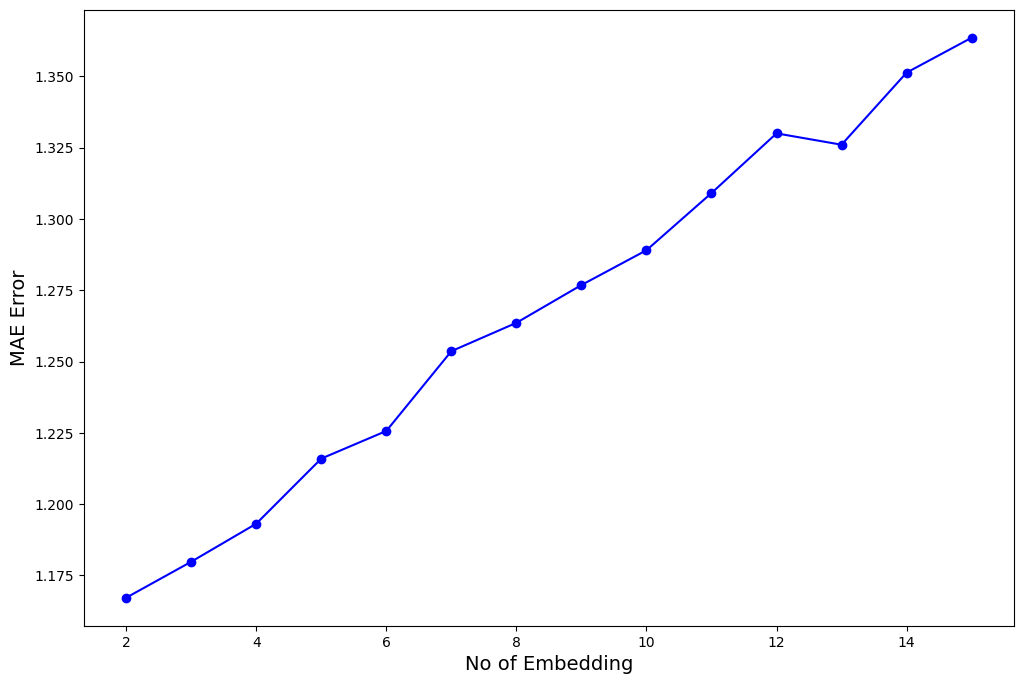

In [ ]:

plt.figure(figsize=(12, 8))
plt.plot(range(2, 16), MAE, "bo-")
plt.xlabel("No of Embedding", fontsize=14)
plt.ylabel("MAE Error", fontsize=14)

MAE Error is increasing with increase in No of Embeddings

As Sparsity of the Matrix is very high, we are not getting Better Results

To get Better Results, we have increase more User-Item Ratings

**Embedding Visualizaton with k=4**

In [ ]:
model = CMF(method="als", k=4, lambda_=0.1, user_bias=True, item_bias=True, verbose=False)
model.fit(user_item1)
user_item_pred = np.dot(model.A_, model.B_.T) + model.user_bias_.reshape(-1, 1)+ model.item_bias_.reshape(1, -1) + model.glob_mean_


In [ ]:
# Users
model.A_.shape

(6040, 4)

In [ ]:

# Items
model.B_.shape

(3706, 4)

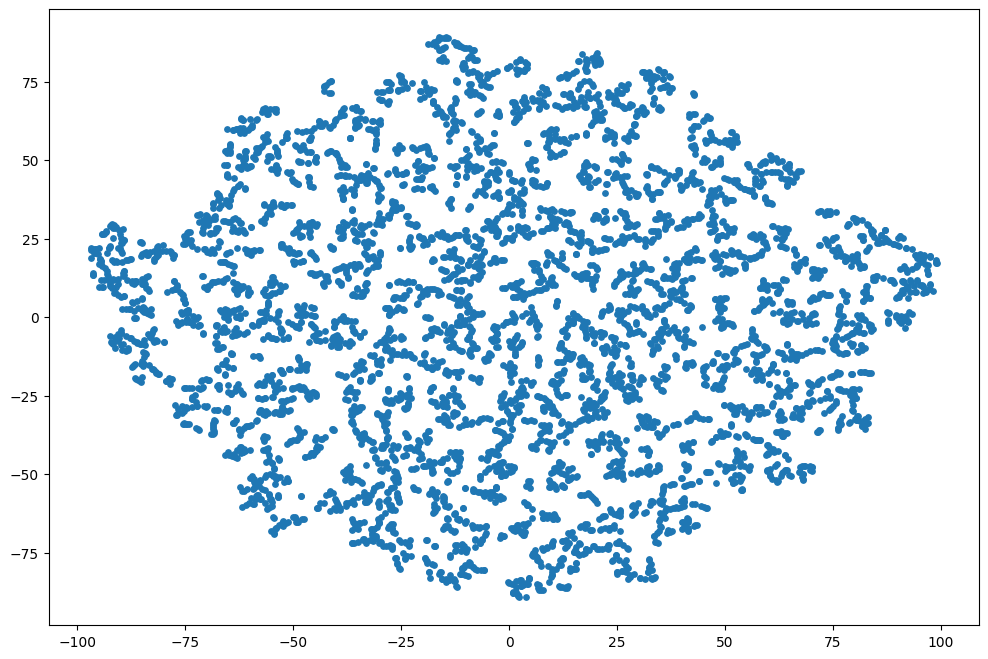

In [ ]:

# User Visualization using tSNE
usertsne = TSNE(n_components = 2, perplexity = 15, random_state = 0)
Z = usertsne.fit_transform(model.A_)


fig, ax = plt.subplots(figsize=(12, 8))
im = ax.scatter(Z[:,0],Z[:,1], s=15)

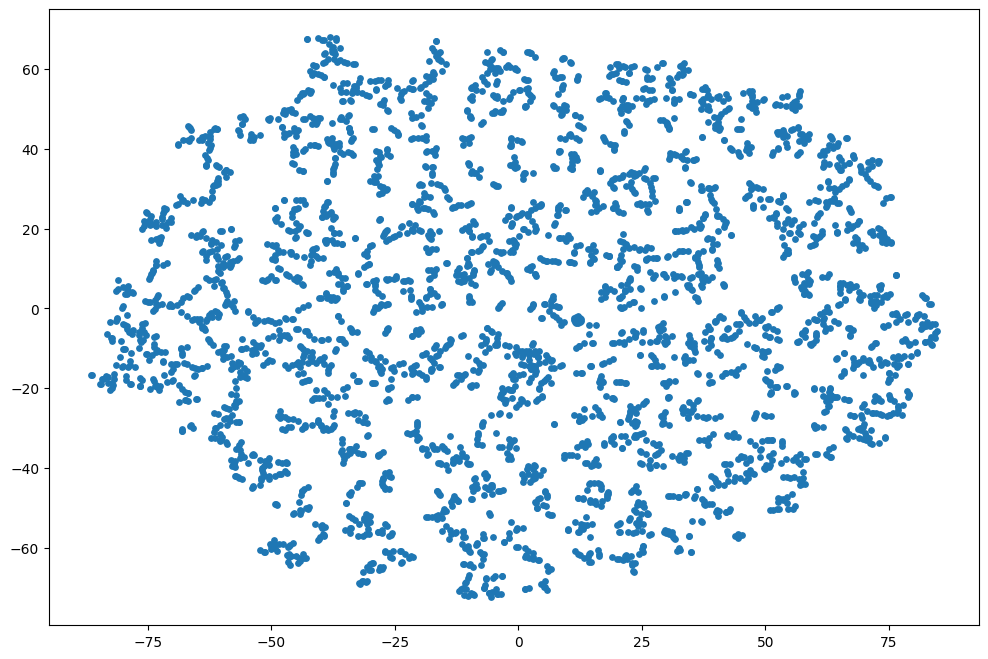

In [ ]:
# Items Visualization using tSNE
itemtsne = TSNE(n_components = 2, perplexity = 15, random_state = 0)
Z = usertsne.fit_transform(model.B_)

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.scatter(Z[:,0],Z[:,1],s=15)

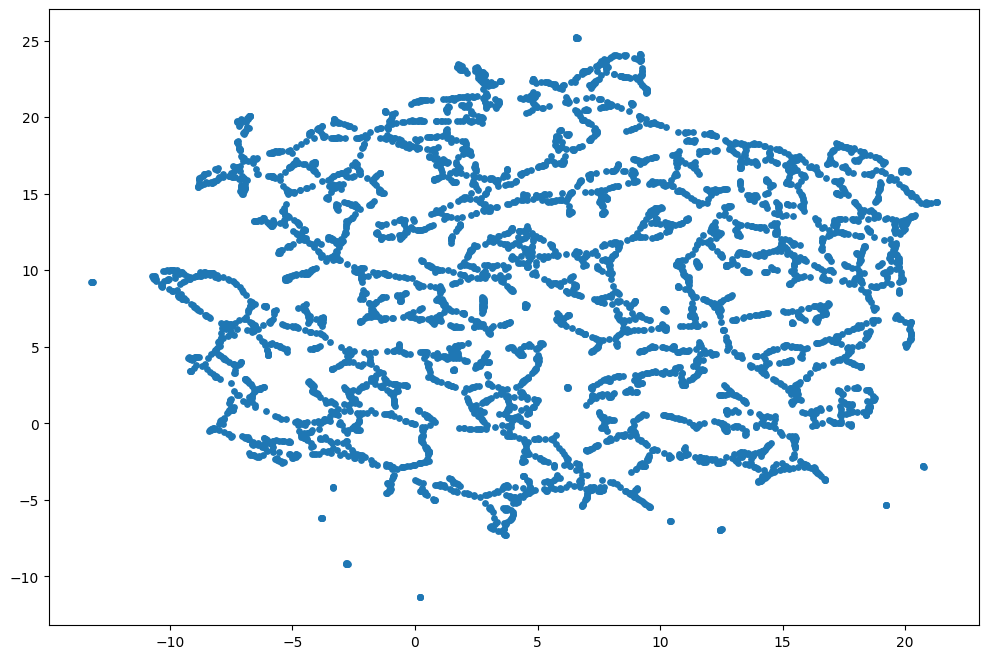

In [ ]:

# Users Visualization using UMAP
userumap = umap.UMAP(n_neighbors=5,min_dist=0.3,metric='correlation')
Z = userumap.fit_transform(model.A_)


fig, ax = plt.subplots(figsize=(12, 8))
im = ax.scatter(Z[:,0],Z[:,1], s=15)

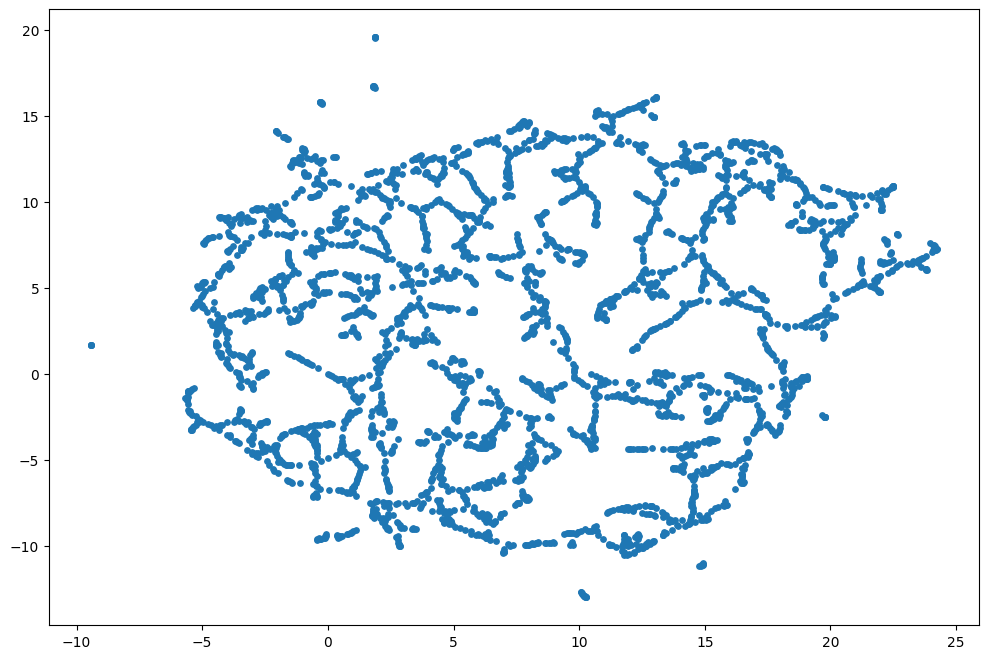

In [ ]:

# Items Visualization using UMAP
itemumap = umap.UMAP(n_neighbors=5,min_dist=0.3,metric='correlation')
Z = itemumap.fit_transform(model.B_)


fig, ax = plt.subplots(figsize=(12, 8))
im = ax.scatter(Z[:,0],Z[:,1], s=15)

From MF Embdedding Visualization, we are not able to clearly see Clusters but can observe some eccentric Users and Items are present from UMAP

**Similarity for Item using Embeddings**

In [ ]:
ItemEmbedding = pd.DataFrame(data=model.B_ , index= user_item.columns)

In [ ]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(ItemEmbedding)
k = "1"
distances, indices = model_knn.kneighbors(ItemEmbedding.loc[k,:].values.reshape(1, -1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for Item {0}:\n'.format(ItemEmbedding.index[i]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, ItemEmbedding.index[indices.flatten()[i]], distances.flatten()[i]))


Recommendations for Item 1:

1: 1552, with distance of 0.0018660426139831543:
2: 2944, with distance of 0.0019789934158325195:
3: 1046, with distance of 0.002614915370941162:
4: 2919, with distance of 0.004396259784698486:
5: 1484, with distance of 0.004983425140380859:


**Similarity for User using Embeddings**

In [ ]:
UserEmbedding = pd.DataFrame(data=model.A_ , index= user_item.index)

In [ ]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(UserEmbedding)
k = "10"
distances, indices = model_knn.kneighbors(UserEmbedding.loc[k,:].values.reshape(1, -1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for User {0}:\n'.format(UserEmbedding.index[i]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, UserEmbedding.index[indices.flatten()[i]], distances.flatten()[i]))


Recommendations for User 1:

1: 1326, with distance of 0.0009621381759643555:
2: 3197, with distance of 0.0028937458992004395:
3: 3137, with distance of 0.0032917261123657227:
4: 12, with distance of 0.0032966136932373047:
5: 3890, with distance of 0.010617494583129883:




As the Matrix Factorization MAE is high, we can see that Recommended users are not same as Earlier Cosine Similarity function Recommendations

**Business Insights**

**Movies**

No of Unique Movie ID are 3783

No of Unique Title are 3733

No of Unique Genres are 296

No of Unique Genressplit are 18

No of Unique Releaseyear are 81

No of Unique Releaseyeargroups are 5

Most of the Movies are in the Genres Drama, Comedy, Thriller & Action

More than 75% of the movies have release year after 1983

Most of the Movies avaiable are of 90's Decade

**Users**

No of Unique USerID are 6040

No of Unique Gender are 2

No of Unique Age are 7

No of Unique Occupation are 21

No of Unique Zipcode are 3439

Majority of the Users occupation

college/grad student

executive/managerial

academic/educator

Minimum no of users are from below Occupations

Farmers

tradesman/craftsman

homemakers

35% of the users are in the Age group "25 ~ 34"


20% of the users are in the Age group "35 ~ 44"


only 4 % of the users are from age group "1~17"


only 6% fo the users are from group >56


72% users are Male Gender only 28% are Female Gender

**Ratings**

No of Unique USerID Rated Movies are 6040


No of Unique Movie_ID Rated are 3706


No of Unique Rating are 5


No of Unique Timestamp are 458455


No of Unique hour are 24


No of Unique dayofweek are 7


No of Unique month are 12


No of Unique year are 4


No of Unique day are 31


35% of the ratings are given as 4

only 23% of ratings are given as 5

Most of the movies are rated/watched in the Night and midnight
Movies are least watched in morning and noon time

*Comparitively movies are mostly watched in Saturdays and Sunday

Least rated/watched on Fridays

Most movies are watched /rated in the month of November & next in August

leastly watched /rated in the month of March


**Overall all Data Analysis:**

Gender has no Bias in Rating Viewpoint for Movies

Age Groups 18 ~ 25, 25 ~ 34, 35 ~ 44, 45 ~ 49 are comparively critical in rating movies in caomparison with other age groups

All Age groups have almost preference order for Genres : Drama--> Comedy --> Action --> Thriller

Female has more preference in Genres - Romance,Comedy,Drame in Comparison with Male

Male has more preference in Genres - Action,Mystery in comparsion with Female

Comparitively Retired & Homemaker People less preference for Action & have more prefence for Comedy and Drama

Compariively 1~18 Age user watch/rate movie in the late night between 21:00 ~ 23:00

Occupation:"college/grad student" have rated most Movies, next most rated are others ,executive/managerial,academic/educator,technician/engineer

Most of the Movie Rating are given by 25 ~ 34 Age Group
Nearly 75% of ratings are done by Males

Men in Black (1997) is most no. of times rated movie
**Item Item Recommendation System:**

Item-Item Recommendation are similar in all 3 Models
Pearson Correlation
Cosine Simialrity
Nearest Neighbours Approach

**How ever little Variation is Observed in Order of REcommendation May due to Type of Metric Used in 3 Models**

Pearson Correlation : Correlation(Variance) Comparison

Cosine Simalarity : Direction in N-Dim Hyperspace & Comparison of Difference in Angle

Nearest Neighbours : Purely on the Basis of Distance
So there is slight Difference in Order of Recommendation
For Example Movie_ID : 1, REcommendation Order as below


Pearson Correlation : 3114,2355,3751,1223,1148

Cosine Simialrity : 1148,1223,2355,3114,3751

Nearest Neighbours Approach : 3114, 2355,3751,1148,1223


**User-User Recommendation System:**

User-User Recommendation using Cosine Simialrity has Given Comparable results when verified with User Data

**Matric Factorization Recommendation System**

Only 4.46 % of ratings are filled in User_Item Interaction Matrix

Sparsity is Very High for User-Item Interaction Matrix

So MAPE [42%], MAE [1.19] Observed... which is very High..Not Reliable

Even with Increasing the no of Embeddings fomr 2 --> 16, MAE increase from 1.165 --> 1.37

So Need to improve Sparity for use of Matrix Factorization

**Drawbacks of Matric Factorization Algorithm**

Predicted rating are not able to get for movies which do not have any Earlier Rating [Kind of Cold Start Problem for Non Rated Movies]
Need Decent Sparsity to get Relaible Values

**Visualization of MF Embedding**

From MF Embdedding Visualization, we are not able to clearly see Clusters but can observe some eccentric Users and Items are present from UMAP

**Recommendations**

Genres like Thriller, Action Romance can be increased as they are 3~ 5th most watched Movies


Mostly in this Plaform Content is watched by Students or White Collar Job Users ....less users from Blue Collar users like Farmer & trader Segment....Need to Figure Schemes & Content to increase their Viewership


Users Have Less Tendency to watch Movies on Fridays , Even if it is Weekend.. So in order not loose User Focus on Fridays, some Exlusive releases or Rent basis Schemes can be provided to capture user even on Friday


Inorder to capture Young Age Users, Party Streaming cn alos be provided for capturing Threatre & Together watching Feeling


Make sure that Each Movie has altleast 1 rating in order not ot loose out in MAtrix Factorization Algorithm


As the User Base is more,User-User Simialrity can be used to Improve REcommendnation to avoid Cold Start Trouble